<div class="title">Ecosistema Spark &ndash; MLlib</div>
<div class="subtitle">Máster en Big Data y Data Science</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

**Configuración inicial**

In [1]:
%%html
<head><link rel="stylesheet" href="notebook.css"></head>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

# Repaso de Spark

## Introducción a Spark

* Apache Spark™ es un motor unificado de análisis para el procesado de datos a gran escala.
* La plataforma fue diseñada con el objetivo de ser *rápida*, de *propósito general*, y *fácil de usar*.
    * Velocidad: $100$ veces más rápido que Hadoop.
    * Propósito general: Spark SQL, grafos (GraphX), Spark Streaming, **aprendizaje automático (MLlib)**.
    * Facilidad de uso: APIs en Java, Scala, **Python**, R y SQL.
    * Funciona sobre Hadoop, Apache Mesos, Kubernetes, en modo local, o en la nube.
* Basado principalmente en el modelo *map-reduce*.

## Spark desde Python

* Para utilizar Spark desde Python se carga el paquete [pyspark](https://spark.apache.org/docs/latest/api/python/index.html), y los programas simplemente acceden al `SparkContext`, un objeto que representa una conexión a un clúster de computación.
    * Cuando se utiliza el *kernel* Pyspark, hay un objeto de este tipo definido automáticamente en la variable `sc`, así que no es necesario crearlo.
    * En el caso de que se esté utilizando un *kernel* genérico de Python, el primer paso será crearlo como:
    ```pyhon
    import pyspark
    sc = pyspark.SparkContext()
    ```

El siguiente código crea el objeto `SparkContext`, en el caso de que no exista previamente.

In [3]:
if not (("sc" in globals()) or ("sc" in locals())):
    print("Creando SparkContext:")
    import pyspark
    sc = pyspark.SparkContext()
else:
    print("SparkContext ya creado:")

print("\t", sc)

SparkContext ya creado:
	 <SparkContext master=local[*] appName=Jupyter Notebook #1>


## RDD

- Un Resilient Distributed Dataset (RDD) es una colección de elementos distribuida en el clúster.
- Es la estructura básica de almacenamiento de información en Spark.
- Cualquier trabajo en Spark consiste en la manipulación de RDDs para obtener un resultado.

### Creación de RDDs

* La primera forma para crear un RDD es cargar los datos de una fuente externa (por ejemplo un fichero).

<div class="qst">

* Cargar el fichero de texto `./data/quijote.txt` en un RDD de nombre `lines` usando la función `textFile()`.

</div>

In [4]:
################################
# Insertar código.
lines = sc.textFile("./data/quijote.txt")
################################

print(type(lines))

<class 'pyspark.rdd.RDD'>


* Otra forma muy común de crear RDDs es distribuir sobre el clúster una colección de objetos existente en el programa principal.

<div class="qst">

* Crear un RDD que contenga números del $1$ al $9$, y guardarlo en una variable con nombre `numbers`  usando la función `parallelize()`.

</div>

In [5]:
################################
# Insertar código.
numbers = sc.parallelize(range(1, 10))
################################

print(type(numbers))

<class 'pyspark.rdd.PipelinedRDD'>


### Operaciones con RDDs

* Los RDDs soportan dos tipos de operaciones:
    * *Transformaciones*: Operaciones que generan un nuevo RDD.
    * *Acciones*: Operaciones que devuelven un resultado al programa principal, o bien lo escriben en un dispositivo de almacenamiento.

#### Transformaciones básicas

* Las dos [transformaciones](https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations) básicas son `map()` y `filter()`.
    * `map()` recibe como argumento una función y genera un nuevo RDD con el resultado de aplicar la función a cada elemento del RDD original.
    * `filter()` recibe como argumento una función y genera un nuevo RDD con los elementos del RDD original para los que la función devuelve `True`.

<div class="qst">

* Utilizar la transformación `filter()` para crear, a partir del RDD `lines`, un nuevo RDD `lines_molino` formado únicamente por las líneas que contenga la palabra `"molino"`.

</div>

In [6]:
################################
# Insertar código.
lines_molino = lines.filter(lambda line: "molino" in line)
################################

print(type(lines_molino))

<class 'pyspark.rdd.PipelinedRDD'>


#### Acciones básicas

* Algunas de las [acciones](https://spark.apache.org/docs/latest/rdd-programming-guide.html#actions) más comunes sobre RDDs son `reduce()`, `collect()`, `first()` y `count()`.
    * `reduce()` recibe como argumento una función que opera sobre dos elementos del mismo tipo que los almacenados en el RDD, y la aplica a los elementos del RDD por pares hasta obtener un único elemento del mismo tipo. Es importante que la función sea conmutativa y asociativa, ya que no hay ninguna garantía de en qué orden se realizará la reducción.
    * `collect()` devuelve todos los elementos de un RDD como un *array*.
    * `first()` devuelve el primer elemento de un RDD.
    * `count()` devuelve el número de elementos de un RDD.

<div class="qst">

* Almacenar en la variable `num_lines` el número de líneas que contienen la palabra `"molino"` (es decir, el número de registros del RDD `lines_molino`).
* Recuperar en la variable `array_lines_molino` las líneas contenidas en el RDD `lines_molino`.

</div>

In [7]:
################################
# Insertar código.
num_lines = lines_molino.count()
array_lines_molino = lines_molino.collect()
################################

print(num_lines)
for line in array_lines_molino:
    print("->", line)

14
-> Autores hay que dicen que la primera aventura que le avino fue la de Puerto Lápice; otros dicen que la de los molinos de viento; pero lo que yo he podido averiguar en este caso, y lo que he hallado escrito en los anales de la Mancha, es que él anduvo todo aquel día, y al anochecer, su rocín y él se hallaron cansados y
-> Y quiso la suerte que cuando llegó a este verso acertó a pasar por allí un labrador de su mismo lugar, y vecino suyo, que venía de llevar una carga de trigo al molino; el cual, viendo aquel hombre allí tendido, se llegó a él y le preguntó que quién era y qué mal sentía que tan tristemente se quejaba. Don Quijote creyó sin duda que aquel era el marqués de Mantua su tío, y así no le respondió otra cosa sino fue proseguir en su romance, donde le daba cuenta de su desgracia y de los amores del hijo del Emperante con su esposa, todo de la misma manera que el romance lo canta. El labrador estaba admirado oyendo aquellos disparates, y quitándole la

#### Map-reduce

* Una de las combinaciones más útiles de Spark es la de **_map-reduce_**.
* Por ejemplo, se puede calcular el número de caracteres de un fichero de la siguiente forma:
    1. Transformando cada línea en el número de caracteres que contiene.
    2. Reduciendo el RDD para sumar todos los elementos.

<div class="qst">

* Crear mediante `map()` un nuevo RDD `chars` que contenga el número de caracteres de cada línea almacenada en el RDD `lines`.
* Obtener el número total de caracteres utilizando `reduce()` sobre el nuevo RDD `chars`, y almacenar el resultado en la variable `num_chars`.

</div>

In [8]:
################################
# Insertar código.
chars = lines.map(lambda line: len(line))
num_chars = chars.reduce(lambda chars_1, chars_2: chars_1 + chars_2)
################################

print("Total number of characters (reduce): {:}".format(num_chars))

Total number of characters (reduce): 1036211


En este caso, existe una función que directamente realiza ese reducción, la función `sum()`, como se muestra a continuación:

In [9]:
num_chars = chars.sum()

print("Total number of characters (sum): {:}".format(num_chars))

Total number of characters (sum): 1036211


#### Evaluación perezosa

* En Spark se utiliza evaluación perezosa (*lazy evaluation*):
    * Las transformaciones sobre los RDDs se evalúan de forma perezosa.
    * No se ejecutan hasta que aparecen en una acción.
    * Esto reduce el número de pasadas necesarias sobre los datos.
    * Es posible forzar a Spark a que ejecute una transformación ejecutando una acción (por ejemplo, `count()`).

De esta forma, el siguiente código no realiza ningún cálculo, ni siquiera carga los datos del fichero.

In [10]:
lines_molino = sc.textFile("./data/quijote.txt").filter(lambda line: "molino" in line)

Mientras que al realizar la llamada a `count()` se desencadena toda la ejecución.

In [11]:
print(lines_molino.count())

14


#### Persistencia

* A veces un RDD se usa más de una vez en un programa.
* Dado que los RDDs se evalúan de forma perezosa, esto puede implicar que se repitan cálculos costosos.
* Para evitar este problema se puede controlar la [persistencia](https://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-persistence) de un RDD a través de la función `persist()`, que permite por ejemplo indicar a Spark que guarde el RDD en memoria o en disco.

In [12]:
from pyspark import StorageLevel
lines.persist(StorageLevel.MEMORY_ONLY)

print(lines.getStorageLevel())

Memory Serialized 1x Replicated


* Para acabar con la persistencia de un RDD se usa el método `unpersist()`.

In [13]:
lines.unpersist()

print(lines.getStorageLevel())

Serialized 1x Replicated


# Repaso de ML

* El **objetivo** del aprendizaje automático (*Machine Learning*, ML) es realizar predicciones o tomar decisiones en base a datos históricos.
* Los datos consisten en un conjunto de ejemplos o **patrones**, cada uno de ellos descrito por un vector de **características**.
* Hay distintos tipos de problemas de aprendizaje automático: **clasificación**, **regresión**, **_clustering_**.
* En los **modelos paramétricos**, el modelo depende de unos parámetros que se ajustan para minimizar la **función de coste** evaluada sobre un conjunto de datos. Este proceso de ajuste de parámetros es el **entrenamiento del modelo**.
* En muchos casos, los modelos dependen también de parámetros de alto nivel o **hiperparámetros** que no pueden ajustarse en el entrenamiento, así que se suelen seleccionar durante una fase de **validación del modelo**.

# Spark MLlib

## Introducción a MLlib

* [MLlib](https://spark.apache.org/docs/latest/ml-guide.html) es una librería de funciones de *Machine Learning* para Spark.
    * Incluye un conjunto de algoritmos que se pueden aplicar a RDDs/DataFrames.
    * No están todos los algoritmos, solo aquellos fácilmente paralelizables que funcionan bien en un clúster de computación.
    * MLlib está diseñada para ejecutar un único algoritmo sobre un conjunto muy grande de datos distribuido en el clúster.
* MLlib proporciona las siguientes herramientas:
    * Extracción de características, transformación y selección de atributos, reducción de la dimensión.
    * Algoritmos de ML (p. ej. clasificación, regresión, *clustering* o filtrado colaborativo).
    * *Pipelines*.
    * Persistencia: herramientas para salvar y cargar algoritmos y modelos.
    * Otras utilidades (álgebra lineal, estadística, etc.).
* En el caso de Python, a esta librería se accede a través de `pyspark.ml`.

## Tipos de datos en MLlib

* MLlib incluye algunos tipos de datos propios, pensados para aplicaciones de ML.

### Vector

* El tipo de dato [`Vector`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.mllib.html#vector-and-matrix), definido dentro del módulo `ml.linalg`, se corresponde a un vector en el sentido matemático.
* Puede definirse de manera densa (especificando todas sus componentes), o de manera dispersa (especificando solo el tamaño total y aquellas componentes que son distintas de $0$).
* Estos vectores se integran con los *arrays* de NumPy.

A continuación se muestran algunos ejemplos sencillos.

In [14]:
from pyspark.ml.linalg import Vectors
import numpy as np

v1 = Vectors.dense([4.0, 5.0, 0.0, 3.0])
v2 = Vectors.sparse(4, [(0, 1.0), (3, -2.0)])
v3 = Vectors.sparse(4, {1: 1.0, 3: 2.0})
v4 = np.array([4.0, 5.0, 0.0, 3.0])

print("v1 =", v1)
print("v2 =", v2)
print("v3 =", v3)
print("v4 =", v4)
print("")
print("v2 (array) =", v2.toArray())
print("v3 (array) =", v3.toArray())
print("")
print("v1 + v2 =", v1 + v2)
print("v3 + v4 =", v3 + v4)
print("")
print("v2 · v3 =", v2.dot(v3))
print("||v2|| =", v2.norm(2))

v1 = [4.0,5.0,0.0,3.0]
v2 = (4,[0,3],[1.0,-2.0])
v3 = (4,[1,3],[1.0,2.0])
v4 = [4. 5. 0. 3.]

v2 (array) = [ 1.  0.  0. -2.]
v3 (array) = [0. 1. 0. 2.]

v1 + v2 = [5.0,5.0,0.0,1.0]
v3 + v4 = [4. 6. 0. 5.]

v2 · v3 = -4.0
||v2|| = 2.23606797749979


<div class="qst">

* Crear un vector disperso en la variable `u1` con el siguiente contenido: $\begin{pmatrix} 0 & 2 & 0 & 0 & 0 & 0 \end{pmatrix} $.
* Crear un vector denso en la variable `u2` con el siguiente contenido: $\begin{pmatrix} 1 & 2 & 3 & 4 & 5 & 6 \end{pmatrix}$.
* Calcular la distancia al cuadrado entre `u1` y `u2` usando la función de instancia `squared_distance()` y almacenarla en `distance`.

</div>

In [15]:
################################
# Insertar código.
u1 = Vectors.sparse(6, [(1, 2)])
u2 = Vectors.dense(np.arange(1, 7))
distance = u1.squared_distance(u2)
################################

print("u1 =", u1)
print("u2 =", u2)
print("distance =", distance)

u1 = (6,[1],[2.0])
u2 = [1.0,2.0,3.0,4.0,5.0,6.0]
distance = 87.0


### LabeledPoint

* El tipo de dato `LabeledPoint` representa un vector de características, junto con su clase o etiqueta.
* Se utiliza en problemas de aprendizaje supervisado (como clasificación y regresión).

<div class="notes">

* Como se verá más adelante, este tipo de dato pertenece a la librería antigua de MLlib, por eso se accede a través de [`mllib.regression`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.mllib.html#regression), y por eso se usa la versión antigua de SparseVector en `mllib.linalg`.

</div>

A continuación se muestran algunos ejemplos sencillos.

In [16]:
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

sample_pos = LabeledPoint(1, [1.0, 2.0, 4.0])
sample_neg = LabeledPoint(0, SparseVector(3, [0, 2], [1.0, 3.0]))

print("sample_pos =", sample_pos)
print("  >> label =", sample_pos.label)
print("  >> features =", sample_pos.features)
print("sample_neg =", sample_neg)
print("  >> label =", sample_neg.label)
print("  >> features =", sample_neg.features)

sample_pos = (1.0,[1.0,2.0,4.0])
  >> label = 1.0
  >> features = [1.0,2.0,4.0]
sample_neg = (0.0,(3,[0,2],[1.0,3.0]))
  >> label = 0.0
  >> features = (3,[0,2],[1.0,3.0])


* En las primeras versiones de Spark, un problema de clasificación o regresión se representaba como un RDD de `LabeledPoint`, en el que los elementos `label` hacían referencia a las clases o *targets* y los elementos `features` hacían referencia a los vectores de características.
* Actualmente:
<div align="center", style="border: 2px solid gray; border-radius: 5px;margin-right: 100px;
  margin-left: 100px; margin-top: 20px; margin-bottom: 20px; padding: 20px;">
<b>The MLlib RDD-based API is now in maintenance mode.</b><br><br>
As of Spark 2.0, the RDD-based APIs in the <code>spark.mllib</code> package have entered maintenance mode.
The primary Machine Learning API for Spark is now the DataFrame-based API in the <code>spark.ml</code> package.
</div>
* Desde la versión 2.0, Spark MLlib trabaja con SQL DataFrames en vez de con RDDs.
* Actualmente coexisten dos APIs en MLlib:
    * Basada en RDD: La antigua, de momento se mantiene (`mllib`).
    * Basada en DataFrame: La principal y más recomendable (`ml`).

### DataFrame

* Un DataFrame es una colección de datos distribuida en el clúster y organizada en columnas, similar a una tabla en una base de datos relacional o a un DataFrame de Pandas.
* El comportamiento es similar al de un RDD, pero con una estructura de tabla.
* Para acceder a la funcionalidad de los DataFrames, es necesario crear una [sesión de Spark](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.html).

La siguiente celda muestra cómo crear una sesión de Spark:

In [17]:
from pyspark.sql import SparkSession 
spark = SparkSession(sc)

#### Carga desde fichero de Texto

* A partir de la sesión de Spark, se puede crear un DataFrame cargando un fichero de texto mediante `read` (que accede al `DataFrameReader`) y la función `text()`.
* Si no se especifican más opciones, creará una única columna (`value`), y una entrada para cada línea leída del fichero.
* Cuando se imprime el DataFrame con `print()`, se puede ver que que la única columna de nombre `value` contiene cadenas de texto. También se puede mostrar la estructura del DataFrame con `printSchema()`.

<div class="qst">

* Cargar el fichero de texto `./data/quijote.txt` en un DataFrame de nombre `lines`.

</div>

In [18]:
################################
# Insertar código.
lines = spark.read.text("./data/quijote.txt")
################################

print(lines)
lines.printSchema()

DataFrame[value: string]
root
 |-- value: string (nullable = true)



* Existen numerosas acciones que se pueden realizar sobre un [DataFrame](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.html), como por ejemplo:
    * `show()` muestra el contenido de un DataFrame (por defecto, solo los primeros $20$ registros).
    * `count()` cuenta el número de registros.
    * `toPandas()` devuelve el DataFrame (en local) convertido en un DataFrame de Pandas.

<div class="qst">

* Mostrar el DataFrame `lines` usando la función `show()`.
* Almacenar el número de elementos del DataFrame `lines` en la variable `num_lines`.
* Convertir el DataFrame `lines` en un DataFramde de Pandas, y almacenarlo en la variable `lines_pandas`.

</div>

In [19]:
################################
# Insertar código.
lines.show()
num_lines = lines.count()
lines_pandas = lines.toPandas()
################################

print("Number of lines: %d" % num_lines)
print("DataFrame of Pandas:\n", lines_pandas)

+--------------------+
|               value|
+--------------------+
|DON QUIJOTE DE LA...|
|Miguel de Cervant...|
|                    |
|       PRIMERA PARTE|
|CAPÍTULO 1: Que ...|
|En un lugar de la...|
|Tuvo muchas veces...|
|En resolución, e...|
|historia más cie...|
|Decía él, que e...|
|En efecto, remata...|
|Imaginábase el p...|
|linaje y patria, ...|
|Limpias, pues, su...|
|Capítulo 2: Que ...|
|Hechas, pues, est...|
|Estos pensamiento...|
|Con estos iba ens...|
|Autores hay que d...|
|muertos de hambre...|
+--------------------+
only showing top 20 rows

Number of lines: 2186
DataFrame of Pandas:
                                                   value
0                              DON QUIJOTE DE LA MANCHA
1                          Miguel de Cervantes Saavedra
2                                                      
3                                         PRIMERA PARTE
4     CAPÍTULO 1: Que trata de la condición y ejer...
...                                       

* También se pueden realizar transformaciones sobre un [DataFrame](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.html), que devuelven otro DataFrame (que se evaluará de forma perezosa):
    * `filter()` (también llamado `where()`) filtra algunos registros, recibiendo para ello un DataFrame de valores Booleanos (por lo general obtenido operando con las columnas, de tipo de dato [Column](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.html), usando funciones como `contains()`, `eqNullSafe()`, `isin()`...) o una cadena con una expresión SQL.
    * `select()` selecciona solo algunas columnas.
    * `drop()` elimina algunas columnas.
    * `limit()` selecciona las primeras filas.
    * `withColumn()` permite añadir una nueva columna.
    * `withColumnRenamed()`permite renombrar una columna.

<div class="qst">

* Utilizar la transformación `filter()` para crear, a partir del DataFrame `lines`, un nuevo DataFrame `lines_molino` formado únicamente por las líneas que contenga la palabra `"molino"`.

</div>

In [20]:
################################
# Insertar código.
lines_molino = lines.filter(lines.value.contains("molino"))
# También se puede usar lines.filter(lines["value"].contains("molino")).
################################

lines_molino.show()
print("Number of lines with molino: %d" % lines_molino.count())

+--------------------+
|               value|
+--------------------+
|Autores hay que d...|
|Y quiso la suerte...|
|Capítulo 8: Del ...|
|En esto descubrie...|
|Y en diciendo est...|
|hurtada alguna pr...|
|¡Sin ventura yo! ...|
|En esto, comenzó...|
|Era el espejo en ...|
|-Y bien -prosigui...|
|-Hermano mío -di...|
|-¡Tomaos con mi p...|
|sepa que le entie...|
|Ya en esto llegar...|
+--------------------+

Number of lines with molino: 14


#### Carga desde fichero JSON

* Otra forma útil de crear un DataFrame es a partir de un archivo JSON como el siguiente:
```json
{"name":"Michael"}
{"name":"Andy", "age":30}
{"name":"Justin", "age":19}
{"name":"Julia", "age":20}
{"name":"Jane", "age":36}
{"name":"Michael", "age":18}
```
* Para ello se utiliza la función `read.json()`.

<div class="qst">

* Cargar el fichero JSON `./data/people.json` en un DataFrame de nombre `people`.

</div>

In [21]:
################################
# Insertar código.
people = spark.read.json("./data/people.json")
################################

people.show()
people.printSchema()

+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
|  20|  Julia|
|  36|   Jane|
|  18|Michael|
+----+-------+

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



A continuación se muestran algunos ejemplos con el DataFrame creado.
En primer lugar, se selecciona solo la columna del nombre.

In [22]:
people.select("name").show()

+-------+
|   name|
+-------+
|Michael|
|   Andy|
| Justin|
|  Julia|
|   Jane|
|Michael|
+-------+



Se seleccionan las entradas con edad menor a $21$, y las que empiezan por `"J"`.

In [23]:
people.filter(people["age"] < 21).show()
people.filter(people["name"].startswith("J")).show()

+---+-------+
|age|   name|
+---+-------+
| 19| Justin|
| 20|  Julia|
| 18|Michael|
+---+-------+

+---+------+
|age|  name|
+---+------+
| 19|Justin|
| 20| Julia|
| 36|  Jane|
+---+------+



<div class="qst">

* Seleccionar los registros del DataFrame `people` que cumplen las dos condiciones anteriores, y almacenarlos en un nuevo DataFrame `people_j21`.

</div>

In [24]:
################################
# Insertar código.
people_j21 = people.filter((people.name.startswith("J")) & (people.age < 21))
################################

people_j21.show()

+---+------+
|age|  name|
+---+------+
| 19|Justin|
| 20| Julia|
+---+------+



# Estadísticas básicas

* El primer paso cuando se va a afrontar un problema de ML es realizar un análisis de los datos recibidos.
* MLlib proporciona herramientas en este sentido en el módulo `ml.stat`.

## Conjunto de datos numéricos

* Para algunos ejemplos se utilizará un conjunto de datos formado por $500$ puntos en tres dimensiones, correspondientes a dos clases de $250$ puntos cada una.

In [25]:
import numpy as np

numbers = np.loadtxt("./data/numbers.txt")
labels = np.repeat([0, 1], 250)

print(numbers)
print(labels)

[[17.11116589  9.63595131  2.34527287]
 [19.18012627  9.94266369 -0.27404596]
 [18.97292128 11.02869364 -1.08796343]
 ...
 [-1.59979128 -0.64364358  3.40608093]
 [-2.58624559 -0.32406842  2.59069081]
 [ 0.71988347  0.70483375  1.65821649]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1

* A partir del *array* de NumPy, se construye un DataFrame sobre los datos, que tendrá una columna llamada `"label"` y otra llamada `"features"`.
* Para ello, se transforma el *array* en una lista de listas, cada una con dos elementos, la etiqueta y las características de tipo `Vector`, y se crea el DataFrame a partir de esta lista.

In [26]:
from pyspark.ml.linalg import Vectors

samples = spark.createDataFrame([[l, Vectors.dense(v)] for l, v in zip(labels.tolist(), numbers)], \
                                ["label", "features"])

samples.show(truncate=False)

+-----+------------------------------------------------------------+
|label|features                                                    |
+-----+------------------------------------------------------------+
|0    |[17.111165885025684,9.635951311173281,2.345272872845365]    |
|0    |[19.180126269125928,9.94266368732471,-0.2740459609652126]   |
|0    |[18.97292128433064,11.0286936370439,-1.0879634329406391]    |
|0    |[22.948892025926195,12.197755525459277,2.8194621519365026]  |
|0    |[18.984126427074788,9.836549137117064,-1.2353155616745144]  |
|0    |[17.150166798966488,8.858936170375616,2.896967714626184]    |
|0    |[22.92080349261344,11.213368814700013,0.9316151957979513]   |
|0    |[16.764981399250075,9.407661258646804,3.803870015604918]    |
|0    |[18.965096548392033,10.977448430265776,1.0211818474607124]  |
|0    |[18.76019433695045,11.583635203870571,-0.14653134992974448] |
|0    |[21.17772758173259,10.463494362719965,3.1483597637399]      |
|0    |[19.921474300594035,10.1575

## Matriz de correlación

* Se puede calcular la matriz de correlación utilizando la función `corr()` de `ml.stat.Correlation`.
* Esta función recibe el DataFrame y la columna sobre la que calcular las estadísticas, y permite elegir entre la correlación de Pearson (por defecto) y la de Spearman.
* Por tanto, se calcula la correlación entre las distintas componentes de los vectores de una columna, no entre distintas columnas.

A continuación se muestra un ejemplo con el DataFrame `samples`.

In [27]:
from pyspark.ml.stat import Correlation

corr_p = Correlation.corr(samples, "features").head()[0]
corr_s = Correlation.corr(samples, "features", method="spearman").head()[0]

print("Pearson correlation matrix:")
print(corr_p)
print("\nSpearman correlation matrix:")
print(corr_s)

Pearson correlation matrix:
DenseMatrix([[1.        , 0.99041192, 0.08396279],
             [0.99041192, 1.        , 0.08708823],
             [0.08396279, 0.08708823, 1.        ]])

Spearman correlation matrix:
DenseMatrix([[1.        , 0.92379096, 0.07581054],
             [0.92379096, 1.        , 0.08512181],
             [0.07581054, 0.08512181, 1.        ]])


<div class="qst">

* Calcular e imprimir la matriz de correlación de Pearson del DataFrame `data`, generado en la siguiente celda.

</div>

In [28]:
data = spark.createDataFrame([[Vectors.dense([1, 1, 0])], \
                              [Vectors.dense([2, 2, 0])], \
                              [Vectors.dense([1, 1, 1])], \
                              [Vectors.dense([2, 2, 0])]], ["numbers"])
data.show()

################################
# Insertar código.
corr_p = Correlation.corr(data, "numbers").head()[0]
print(corr_p)
################################

+-------------+
|      numbers|
+-------------+
|[1.0,1.0,0.0]|
|[2.0,2.0,0.0]|
|[1.0,1.0,1.0]|
|[2.0,2.0,0.0]|
+-------------+

DenseMatrix([[ 1.        ,  1.        , -0.57735027],
             [ 1.        ,  1.        , -0.57735027],
             [-0.57735027, -0.57735027,  1.        ]])


## Test Chi-Cuadrado

* El test $\chi^2$, o test de independencia de Pearson, sirve para medir la independencia entre variables aleatorias discretas.
    * Es especialmente útil en ML, ya que sirve para calcular la dependencia entre cada característica y la clase real, siempre que los atributos sean categóricos.
    * Valores más pequeños del test suelen indicar mayor dependencia.
* Se puede acceder a este test con la función `test()` de `ml.stat.ChiSquareTest`, que recibe como argumentos el DataFrame, el nombre de la columna de características y el nombre de la columna de etiquetas.

A continuación se muestra un ejemplo con el RDD `samples`, en el que se sustituyen las características originales por características categóricas.

In [29]:
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.linalg import Vectors

samples_cat = spark.createDataFrame([[l, Vectors.dense(v)] for l, v in \
                                     zip(labels.tolist(), numbers > numbers.mean(axis = 0))],\
                                    ["label", "features-cat"])

samples_cat.show()

chi_t = ChiSquareTest.test(samples_cat, "features-cat", "label").head()

print("pValues:", chi_t.pValues)

+-----+-------------+
|label| features-cat|
+-----+-------------+
|    0|[1.0,1.0,1.0]|
|    0|[1.0,1.0,0.0]|
|    0|[1.0,1.0,0.0]|
|    0|[1.0,1.0,1.0]|
|    0|[1.0,1.0,0.0]|
|    0|[1.0,1.0,1.0]|
|    0|[1.0,1.0,0.0]|
|    0|[1.0,1.0,1.0]|
|    0|[1.0,1.0,1.0]|
|    0|[1.0,1.0,0.0]|
|    0|[1.0,1.0,1.0]|
|    0|[1.0,1.0,0.0]|
|    0|[1.0,1.0,1.0]|
|    0|[1.0,1.0,1.0]|
|    0|[1.0,1.0,0.0]|
|    0|[1.0,1.0,1.0]|
|    0|[1.0,1.0,0.0]|
|    0|[1.0,1.0,1.0]|
|    0|[1.0,1.0,0.0]|
|    0|[1.0,1.0,0.0]|
+-----+-------------+
only showing top 20 rows

pValues: [0.0,0.0,0.12813128078870484]


<div class="qst">

* Calcular e imprimir el $p$-valor del test $\chi^2$ entre las dos columnas del DataFrame `data`, generado en la siguiente celda.
* Determinar cuál de las dos características es más informativa de acuerdo al resultado del test.

</div>

In [30]:
data = spark.createDataFrame([[Vectors.dense([0, 0]), 0], \
                              [Vectors.dense([1, 5]), 1], \
                              [Vectors.dense([0, 0]), 0], \
                              [Vectors.dense([0, 5]), 1]], ["features",  "label"])
data.show()

################################
# Insertar código.
chi_t = ChiSquareTest.test(data, "features", "label").head()
print("pValues:", chi_t.pValues)
print("Most informative feature:", chi_t.pValues.argmin() + 1)
################################

+---------+-----+
| features|label|
+---------+-----+
|[0.0,0.0]|    0|
|[1.0,5.0]|    1|
|[0.0,0.0]|    0|
|[0.0,5.0]|    1|
+---------+-----+

pValues: [0.24821307898992373,0.04550026389635764]
Most informative feature: 2


## Summarizer

* La clase [`ml.stat.Summarizer`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.stat.Summarizer.html) permite obtener un resumen con algunas de las principales estadísticas asociadas a una columna de tipo `Vector`, por lo que es muy útil para analizar las características.

A continuación se incluye un ejemplo, en el que se obtiene la media, la varianza, el valor máximo y el mínimo de cada característica.

In [31]:
from pyspark.ml.stat import Summarizer

metrics = ("mean", "variance", "min", "max")
summarizer = Summarizer.metrics(*metrics)
summary = samples.select(summarizer.summary(samples.features)).head()[0]

for i, metric in enumerate(metrics):
    print(metric)
    for val in summary[i]:
        print("%8.2f\t" % val, end='')
    print("")

mean
    9.07	    5.03	    1.01	
variance
  101.98	   26.35	    3.11	
min
   -4.19	   -2.11	   -4.47	
max
   23.65	   13.20	    5.51	


* Cuando se usa un DataFrame con una estructura como la anterior no funciona utilizar directamente la función `summary()` del DataFrame, ya que la columna de características contiene datos tipo `Vector`, no datos numéricos, así que solo se mostrarán las estadísticas de la etiqueta.

In [32]:
samples.summary().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|               500|
|   mean|               0.5|
| stddev|0.5005007512521913|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 1|
|    max|                 1|
+-------+------------------+



<div class="qst">

* Calcular la media de los elementos del DataFrame `data`, generado en la siguiente celda.

</div>

In [33]:
data = spark.createDataFrame([[Vectors.dense([1, 1, 0])], \
                              [Vectors.dense([2, 2, 0])], \
                              [Vectors.dense([1, 1, 1])], \
                              [Vectors.dense([2, 2, 0])]], ["numbers"])
data.show()

################################
# Insertar código.
print("Mean:", data.select(Summarizer.metrics("mean").summary(data.numbers)).head()[0].mean)
################################

+-------------+
|      numbers|
+-------------+
|[1.0,1.0,0.0]|
|[2.0,2.0,0.0]|
|[1.0,1.0,1.0]|
|[2.0,2.0,0.0]|
+-------------+

Mean: [1.5,1.5,0.25]


# Flujo de trabajo en MLlib

## Conceptos básicos

* **DataFrame:**
    * Estructura básica para almacenar los datos en forma de tabla con filas y columnas.
    * Equivale a un RDD pero con estructura.
* **Transformer:**
    * Algoritmo que transforma un DataFrame en otro DataFrame, similar a las transformaciones de los RDDs.
    * Todos los Transformers implementan el método `transform()`.
    * Un modelo predictivo es un Transformer que transforma un DataFrame con los vectores de características en otro DataFrame con las predicciones.
* **Estimator:**
    * Algoritmo que se aplica a un DataFrame para obtener un Transformer.
    * Todos los Estimators implementan el método `fit()`.
    * Un algoritmo de aprendizaje automático es un Estimator que se entrena con los datos de un DataFrame para obtener un modelo.
* **Pipeline:**
    * Secuencia de algoritmos que procesan los datos y aprenden a partir de ellos.
    * En MLlib, equivale a una cadena de Transformers y Estimators que determina el flujo de trabajo en un problema de ML.

## Flujo de trabajo

1. De manera general, los algoritmos son objetos *Estimator* que se entrenan (`fit()`) usando un conjunto de datos almacenado en un *DataFrame*.
2. El resultado del entrenamiento es un modelo almacenado en un objeto *Transformer*.
3. Este último se puede aplicar (`transform()`) a otro conjunto de datos para obtener predicciones.

* Varios *Transformers* y/o *Estimators* se pueden encadenar en un *Pipeline* para definir el flujo de trabajo de un algoritmo, de manera que todo el proceso realizado durante el entrenamiento se pueda repetir de forma coherente a la hora de predecir sobre nuevos ejemplos.

# Preproceso de los datos

* El primer paso para afrontar con éxito un problema de ML es realizar un preproceso adecuado de los datos.
* En MLlib hay muchos mecanismos ya implementados para el tratamiento de los datos, dentro del módulo `ml.feature`.
* En la mayoría de casos, funcionan como Estimators. Es decir, primero hay que realizar un ajuste a los datos con la función `fit()`, y después se pueden transformar los datos (tanto los de entrenamiento como los datos nuevos) con `transform()`.

## StringIndexer

* La mayoría de las utilidades de MLlib funcionan con datos numéricos.
* Uno de los primeros pasos, por tanto, es codificar las características categóricas, representadas por etiquetas, en categorías numéricas.
* En Spark esto se puede hacer usando el Estimator [`ml.feature.StringIndexer`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html), que transforma cada cadena en un número distinto. Para ello, recibe como argumentos la columna de entrada y la de salida.

A continuación, se muestra un ejemplo sencillo para ilustrar su funcionamiento.

In [34]:
from pyspark.ml.feature import StringIndexer

# Datos categóricos.
category_str = spark.createDataFrame([['a'], ['b'], ['c'], ['b'], ['c'], ['a']], ["category"])
category_str.show()

# Estimator.
string_es = StringIndexer(inputCol="category", outputCol="category_ind")
# Transformer.
string_tr = string_es.fit(category_str)

# Datos transformados.
category_ind = string_tr.transform(category_str)

category_ind.show()

+--------+
|category|
+--------+
|       a|
|       b|
|       c|
|       b|
|       c|
|       a|
+--------+

+--------+------------+
|category|category_ind|
+--------+------------+
|       a|         0.0|
|       b|         1.0|
|       c|         2.0|
|       b|         1.0|
|       c|         2.0|
|       a|         0.0|
+--------+------------+



## PCA

* El Análisis de Componentes Principales (PCA) permite reducir el número de características, transformándolas y reteniendo solo algunas de ellas, de manera que se mantenga la mayor parte de información (varianza) de los datos posible.
* En Spark se puede hacer PCA a través del Estimator [`ml.feature.PCA`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.PCA.html), que permite especificar el número de dimensiones de salida, así como la columna de entrada y la de salida.

A continuación se incluye un ejemplo de PCA, utilizando el DataFrame numérico `samples` cargado antes.

In [35]:
from pyspark.ml.feature import PCA

# Estimator.
pca_es = PCA(k=2, inputCol="features", outputCol="features_pca")
# Transformer.
pca_tr = pca_es.fit(samples)

# Datos transformados.
samples_pca = pca_tr.transform(samples)

samples_pca.show(n=5, truncate=False)

+-----+----------------------------------------------------------+-----------------------------------------+
|label|features                                                  |features_pca                             |
+-----+----------------------------------------------------------+-----------------------------------------+
|0    |[17.111165885025684,9.635951311173281,2.345272872845365]  |[-19.6480139428421,-2.088841238846846]   |
|0    |[19.180126269125928,9.94266368732471,-0.2740459609652126] |[-21.5972020880208,0.5641002130771292]   |
|0    |[18.97292128433064,11.0286936370439,-1.0879634329406391]  |[-21.891159600319572,1.370516741848743]  |
|0    |[22.948892025926195,12.197755525459277,2.8194621519365026]|[-26.019488754590444,-2.4730132090365586]|
|0    |[18.984126427074788,9.836549137117064,-1.2353155616745144]|[-21.361413774806067,1.5222769222045778] |
+-----+----------------------------------------------------------+-----------------------------------------+
only showing top 5 

## PolynomialExpansion

* Una aproximación para añadir información no lineal a los datos es usar la expansión polinómica, que calcula productos entre las distintas características hasta el grado especificado.
    * Por ejemplo, la expansión polinómica de grado $2$ de un vector de $3$ características sería la siguiente:
$$ \begin{pmatrix} x_1 & x_2 & x_3 \end{pmatrix} \to \begin{pmatrix} x_1 & x_1^2 & x_2 & x_1 x_2 & x_2^2 & x_3 & x_1 x_3 & x_2 x_3 & x_3^2 \end{pmatrix} . $$
* Esta transformación está implementada en el Transformer [`ml.feature.PolynomialExpansion`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.PolynomialExpansion.html).
* En este caso, se trata directamente de un Transformer, ya que no hace falta ajustarlo a los datos.

En el siguiente ejemplo es muestra la transformación polinómica de grado $2$ del DataFrame `samples`, que convertirá las $3$ características iniciales en $9$.

In [36]:
from pyspark.ml.feature import PolynomialExpansion

# Transformer.
poly_tr = PolynomialExpansion(degree=2, inputCol="features", outputCol="features_poly")

# Datos transformados.
samples_poly = poly_tr.transform(samples)

samples_poly.show(n=1, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 label         | 0                                                                                                                                                                     
 features      | [17.111165885025684,9.635951311173281,2.345272872845365]                                                                                                              
 features_poly | [17.111165885025684,292.7919979448668,9.635951311173281,164.88236134551676,92.85155767130207,2.345272872845365,40.13035317290779,22.59893521415342,5.500304848104351] 
only showing top 1 row



## OneHotEncoder

* La mayoría de los algoritmos de aprendizaje en MLlib no tratan adecuadamente las variables categóricas, incluso aunque sean numéricas.
* Una aproximación muy común para paliar esta limitación es usar una codificación de tipo *One-Hot*, que evita introducir una métrica arbitraria en las características generadas.
    * Por ejemplo, si hay $4$ categorías se producirá la siguiente codificación:
$$
 0 \to \begin{pmatrix} 1 & 0 & 0 \end{pmatrix} , \\
 1 \to \begin{pmatrix} 0 & 1 & 0 \end{pmatrix} , \\
 2 \to \begin{pmatrix} 0 & 0 & 1 \end{pmatrix} , \\
 3 \to \begin{pmatrix} 0 & 0 & 0 \end{pmatrix} .
$$
    * La última categoría, por lo general, no produce columna porque sería linealmente dependiente de las demás.
* Esta transformación está implementada en el Estimator [`ml.feature.OneHotEncoderEstimator`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.OneHotEncoder.html).

A continuación se muestra un ejemplo de esta codificación, usando las características generadas antes con el StringIndexer, de manera que la transformación total es:
$$
 a \to 0 \to \begin{pmatrix} 1 & 0 \end{pmatrix} , \\
 b \to 1 \to \begin{pmatrix} 0 & 1 \end{pmatrix} , \\
 c \to 2 \to \begin{pmatrix} 0 & 0 \end{pmatrix} .
$$

In [37]:
from pyspark.ml.feature import OneHotEncoder

category_ind.show()

# Estimator.
enc_es = OneHotEncoder(inputCols=["category_ind"], outputCols=["category_ind_oh"])
# Transformer.
enc_tr = enc_es.fit(category_ind)

# Datos transformados.
category_ind_oh = enc_tr.transform(category_ind)

category_ind_oh.show()

+--------+------------+
|category|category_ind|
+--------+------------+
|       a|         0.0|
|       b|         1.0|
|       c|         2.0|
|       b|         1.0|
|       c|         2.0|
|       a|         0.0|
+--------+------------+

+--------+------------+---------------+
|category|category_ind|category_ind_oh|
+--------+------------+---------------+
|       a|         0.0|  (2,[0],[1.0])|
|       b|         1.0|  (2,[1],[1.0])|
|       c|         2.0|      (2,[],[])|
|       b|         1.0|  (2,[1],[1.0])|
|       c|         2.0|      (2,[],[])|
|       a|         0.0|  (2,[0],[1.0])|
+--------+------------+---------------+



## VectorAssembler

* Los modelos predictivos de MLlib funcionan usando una única columna de características, cuyos elementos son de tipo `Vector`.
* Sin embargo, en muchos casos el DataFrame estará compuesto por más de una columna, bien porque se tiene estructurado de esta forma, o bien porque se han generado nuevas características con algunos de los mecanismos de preproceso.
* En estos casos, una herramienta útil es el Transformer [`ml.feature.VectorAssembler`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html), que permite concatenar varias columnas en una única.

A continuación se muestra un ejemplo con el DataFrame `samples_pca`.

In [38]:
from pyspark.ml.feature import VectorAssembler

# Transformer.
assembler_tr = VectorAssembler(inputCols=["features", "features_pca"], outputCol="features_join")

# Datos transformados.
samples_pca_join = assembler_tr.transform(samples_pca)

samples_pca_join.show(n=1, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------
 label         | 0                                                                                             
 features      | [17.111165885025684,9.635951311173281,2.345272872845365]                                      
 features_pca  | [-19.6480139428421,-2.088841238846846]                                                        
 features_join | [17.111165885025684,9.635951311173281,2.345272872845365,-19.6480139428421,-2.088841238846846] 
only showing top 1 row



## StandardScaler

* Muchos modelos predictivos dependen del escalado de los datos, ya que distintas escalas en distintas características pueden afectar a la importancia relativa de cada una dentro del modelo.
* Por ello, lo más común es escalar los datos, por ejemplo para que tengan media $0$ y desviación $1$.
* Este escalado está implementado en MLlib en el Estimator [`ml.feature.SandardScaler`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html).

A continuación se muestra un ejemplo de su uso con el DataFrame `samples`.

In [39]:
from pyspark.ml.stat import Summarizer
from pyspark.ml.feature import StandardScaler

# Estimator.
scaler_es = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="features_sc")
# Transformer.
scaler_tr = scaler_es.fit(samples)

# Datos transformados.
samples_sc = scaler_tr.transform(samples)

print("Original:\n", \
      samples_sc.select(Summarizer.metrics("mean", "variance").summary(samples_sc.features)).head()[0])
print("Scaled:\n", \
      samples_sc.select(Summarizer.metrics("mean", "variance").summary(samples_sc.features_sc)).head()[0])

Original:
 Row(mean=DenseVector([9.0678, 5.0322, 1.011]), variance=DenseVector([101.9784, 26.3542, 3.1114]))
Scaled:
 Row(mean=DenseVector([0.0, -0.0, -0.0]), variance=DenseVector([1.0, 1.0, 1.0]))


## Tokenizer y HashingTF

* En la actualidad, multitud de aplicaciones de ML utilizan como datos de partida textos en lenguaje natural.
* En ese caso, es importante ser capaz de codificar los textos de manera que puedan ser procesados por los modelos predictivos.
* Una de las aproximaciones más sencillas consiste en dividir cada texto en las palabras que lo conforman, y después crear un vector de características donde cada dimensión indica el número de veces que aparece una determinada palabra.
* Estas aproximaciones están implementadas en los Transformers [`ml.feature.Tokenizer`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Tokenizer.html), que divide el texto en las palabras que lo componen, y [`ml.feature.HashingTF`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.HashingTF.html), que crea el vector de características transformando cada palabra en una característica usando una función *hash*, y asignando a esa característica el número de veces que aparece la palabra.

A continuación se muestra un ejemplo muy sencillo de ambas utilidades.

In [40]:
from pyspark.ml.feature import Tokenizer, HashingTF
texts = spark.createDataFrame([["Some text about words"], \
                               ["more about words"], \
                               ["terms regarding numbers"], \
                               ["More About NUMBERS numbers"]], ["text"])

# Transformers.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashing = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")

# Esto se puede hacer de forma más elegante usando pipelines, como se verá más adelante.
texts_hash = hashing.transform(tokenizer.transform(texts))
texts_hash.show(truncate=False)

+--------------------------+-------------------------------+------------------------------------------------------+
|text                      |words                          |features                                              |
+--------------------------+-------------------------------+------------------------------------------------------+
|Some text about words     |[some, text, about, words]     |(262144,[18700,19208,143985,151864],[1.0,1.0,1.0,1.0])|
|more about words          |[more, about, words]           |(262144,[18700,151864,239029],[1.0,1.0,1.0])          |
|terms regarding numbers   |[terms, regarding, numbers]    |(262144,[94311,114159,183375],[1.0,1.0,1.0])          |
|More About NUMBERS numbers|[more, about, numbers, numbers]|(262144,[18700,94311,239029],[1.0,2.0,1.0])           |
+--------------------------+-------------------------------+------------------------------------------------------+



## Otros algoritmos

* Existen muchos otros algoritmos para preprocesar los datos en Spark, por lo que a la hora de enfrentar algún problema nuevo siempre es conveniente hacer un repaso de las herramientas disponibles.
    
<div class="info"><a href=https://spark.apache.org/docs/latest/ml-features.html>Herramientas de preproceso de Spark</a></div>

## Ejercicio de preproceso

<div class="qst">

* Dado el DataFrame `data`, generado en la siguiente celda, crear un nuevo DataFrame `data_pr` que contenga una columna `"features"` con los siguientes elementos concatenados:
    * La codificación *One-Hot* de la columna `"category"`.
    * Las características extraídas mediante HashingTF de las palabras de la columna `"text"`.
    * La transformación PCA a dimensión $2$ sobre los datos de la columna `"vector"`, que previamente habrá que estandarizar para que tenga media $0$ y varianza $1$.

</div>

In [41]:
data = spark.createDataFrame([["a", "dog cat", Vectors.dense([1, 1, 0])], \
                               ["a", "cat rabbit", Vectors.dense([0, 1, 1])], \
                               ["b", "mouse", Vectors.dense([2, 2, -1])], \
                               ["c", "elephant dog", Vectors.dense([1, 1, 4])], \
                               ["b", "cat cat cat", Vectors.dense([0, 0, 0])]], \
                              ["category", "text", "vector"])
data.show()

################################
# Insertar código.
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import Tokenizer, HashingTF
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.feature import VectorAssembler

data_pr = StringIndexer(inputCol="category", \
                        outputCol="category_in").fit(data).transform(data)
data_pr = OneHotEncoder(inputCols=["category_in"], \
                        outputCols=["category_oh"]).fit(data_pr).transform(data_pr)
data_pr = Tokenizer(inputCol="text", \
                    outputCol="words").transform(data_pr)
data_pr = HashingTF(inputCol="words", \
                    outputCol="text_htf").transform(data_pr)
data_pr = StandardScaler(withMean=True,
                         withStd=True,
                         inputCol="vector", \
                         outputCol="vector_sc").fit(data_pr).transform(data_pr)
data_pr = PCA(k=2, inputCol="vector_sc", \
              outputCol="vector_pca").fit(data_pr).transform(data_pr)
data_pr = VectorAssembler(inputCols=["category_oh", "text_htf", "vector_pca"], \
                          outputCol="features").transform(data_pr)

data_pr.select("features").show(truncate=False)
################################

+--------+------------+--------------+
|category|        text|        vector|
+--------+------------+--------------+
|       a|     dog cat| [1.0,1.0,0.0]|
|       a|  cat rabbit| [0.0,1.0,1.0]|
|       b|       mouse|[2.0,2.0,-1.0]|
|       c|elephant dog| [1.0,1.0,4.0]|
|       b| cat cat cat| [0.0,0.0,0.0]|
+--------+------------+--------------+

+-----------------------------------------------------------------------------------------------+
|features                                                                                       |
+-----------------------------------------------------------------------------------------------+
|(262148,[0,54558,141365,262146,262147],[1.0,1.0,1.0,-0.27648331316771046,-0.35412231430798624])|
|(262148,[0,93613,141365,262146,262147],[1.0,1.0,1.0,0.6789506047012545,-0.08354590247742234])  |
|(262148,[1,174393,262146,262147],[1.0,1.0,-2.1934256684460784,-0.3486253900954449])            |
|(262148,[54558,211673,262146,262147],[1.0,1.0,0.29282688412

# Clasificación

* Los problemas de clasificación son problemas supervisados donde las etiquetas son discretas.

## Conjunto de datos de clasificación

* Como ilustración se utilizará el conjunto de datos *iris*, un problema básico de 3 clases fácilmente separables.
* Este conjunto se puede cargar utilizando la función [`sklearn.datasets.load_iris()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris).

In [42]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

from pyspark.sql import SparkSession
spark = SparkSession(sc)

data = load_iris()
iris = spark.createDataFrame(pd.DataFrame(data=np.column_stack([data["data"], data["target"]]),
                                          columns=(data["feature_names"] + ["label"])))

iris.show()

+-----------------+----------------+-----------------+----------------+-----+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|
+-----------------+----------------+-----------------+----------------+-----+
|              5.1|             3.5|              1.4|             0.2|  0.0|
|              4.9|             3.0|              1.4|             0.2|  0.0|
|              4.7|             3.2|              1.3|             0.2|  0.0|
|              4.6|             3.1|              1.5|             0.2|  0.0|
|              5.0|             3.6|              1.4|             0.2|  0.0|
|              5.4|             3.9|              1.7|             0.4|  0.0|
|              4.6|             3.4|              1.4|             0.3|  0.0|
|              5.0|             3.4|              1.5|             0.2|  0.0|
|              4.4|             2.9|              1.4|             0.2|  0.0|
|              4.9|             3.1|              1.5|          

* Para poder aplicar los modelos de Spark, es necesario concatenar todas las características en una sola columna.
* La aproximación usual en los problemas supervisados es dividir el conjunto de datos en entrenamiento y test (p. ej. en una proporción $70\% / 30\%$).
    * En Spark se puede hacer esta partición con `randomSplit()`.

In [43]:
from pyspark.ml.feature import VectorAssembler

iris_join = VectorAssembler(inputCols=iris.columns[:-1], outputCol="features").transform(iris)

iris_tr, iris_te = iris_join.randomSplit([0.7, 0.3], seed=1234)

iris_tr.show()

+-----------------+----------------+-----------------+----------------+-----+-----------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|         features|
+-----------------+----------------+-----------------+----------------+-----+-----------------+
|              4.4|             3.0|              1.3|             0.2|  0.0|[4.4,3.0,1.3,0.2]|
|              4.4|             3.2|              1.3|             0.2|  0.0|[4.4,3.2,1.3,0.2]|
|              4.6|             3.1|              1.5|             0.2|  0.0|[4.6,3.1,1.5,0.2]|
|              4.6|             3.2|              1.4|             0.2|  0.0|[4.6,3.2,1.4,0.2]|
|              4.6|             3.4|              1.4|             0.3|  0.0|[4.6,3.4,1.4,0.3]|
|              4.6|             3.6|              1.0|             0.2|  0.0|[4.6,3.6,1.0,0.2]|
|              4.7|             3.2|              1.3|             0.2|  0.0|[4.7,3.2,1.3,0.2]|
|              4.7|             3.2|    

## Entrenamiento en clasificación

* El primer paso es entrenar un modelo.
* Se utilizará el Estimator correspondiente al modelo y algoritmo de entrenamiento que se elija.
* En el caso concreto de problemas de clasificación, estos Estimators se encuentran en el módulo [`ml.classification`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#classification).

El siguiente código entrena un modelo de regresión logística multinomial (ya que el problema tiene tres clases) con un parámetro de regularización de $0.1$.
Para ello, primero se crea el Estimator, y luego se utiliza el método `fit()` para obtener el modelo entrenado.

In [44]:
from pyspark.ml.classification import LogisticRegression

# Estimator.
logreg_es = LogisticRegression(regParam=1e-1)
# Transformer.
logreg_tr = logreg_es.fit(iris_tr)

print(logreg_tr)
# En este caso el modelo tiene un resumen de los resultados (no siempre es así).
print("\nTraining accuracy: {:.2f}%".format(100 * logreg_tr.summary.accuracy))

LogisticRegressionModel: uid=LogisticRegression_afaaf7454a6f, numClasses=3, numFeatures=4

Training accuracy: 91.92%


## Predicción en clasificación

* Tras el entrenamiento, los modelos son objetos Transformer que pueden realizar predicciones sobre un DataFrame con nuevos puntos.
* En el caso particular del modelo de regresión logística, como resultado de la predicción aparecen tres nuevas columnas:
    * `rawPrediction`: Contiene la transformación lineal para cada clase.
    * `probability`: Contiene la probabilidad de cada clase.
    * `prediction`: Contiene la clase predicha.

A continuación se realiza la predicción sobre el conjunto de test.

In [45]:
pred_logreg = logreg_tr.transform(iris_te)

pred_logreg.select(pred_logreg.columns[-3:]).show(n=5, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------------------------
 rawPrediction | [2.3567188901908285,0.4814826329875319,-2.8382015231783613]   
 probability   | [0.8629144747935783,0.13230095992454985,0.004784565281871651] 
 prediction    | 0.0                                                           
-RECORD 1----------------------------------------------------------------------
 rawPrediction | [1.9955290674986597,0.6132109704644715,-2.608740037963133]    
 probability   | [0.7930182295410676,0.1990444392102776,0.007937331248654632]  
 prediction    | 0.0                                                           
-RECORD 2----------------------------------------------------------------------
 rawPrediction | [1.224193687264645,1.3471075227957243,-2.5713012100603714]    
 probability   | [0.4644123671001296,0.5251514595027708,0.01043617339709959]   
 prediction    | 1.0                                                           
-RECORD 3-------------------------------

## Evaluación en clasificación

* Una parte fundamental del ML es el análisis de los resultados obtenidos.
* El módulo [`ml.evaluation`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#evaluation) permite acceder a herramientas (Evaluators) para evaluar los modelos de ML en distintos tipos de problema.
* En el caso de problemas de clasificación, existen dos Evaluators distintos:
    * [`ml.evaluation.BinaryClassificationEvaluator`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html), para problemas de clasificación binaria, que permite calcular las siguientes métricas:
        * `"areaUnderROC"` (por defecto), calcula el área bajo la curva ROC.
        * `"areaUnderPR"`, calcula el área bajo la curva PR.
    * [`ml.evaluation.MulticlassClassificationEvaluator`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html), para problemas de clasificación multiclase, permite calcular, entre otras, las siguiente métricas:
        * `"f1"` (por defecto), calcula el Valor-F.
        * `"weightedPrecision"`, calcula la precisión media ponderada.
        * `"weightedRecall"`, calcula la exhaustividad (*recall*) media ponderada.
        * `"accuracy"`, calcula la tasa de acierto.
* Otras métricas (por ejemplo la tasa de aciertos o fallos) se pueden calcular manipulando directamente el DataFrame con las predicciones.

La siguiente celda muestra un ejemplo de cómo calcular las cuatro medidas anteriores para clasificación multiclase, con las predicciones del modelo de regresión logística.

In [46]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()

print("F1:  {:5.2f}%".format(100 * evaluator.evaluate(pred_logreg)))
print("W-P: {:5.2f}%".format(100 * evaluator.evaluate(pred_logreg, {evaluator.metricName: "weightedPrecision"})))
print("W-R: {:5.2f}%".format(100 * evaluator.evaluate(pred_logreg, {evaluator.metricName: "weightedRecall"})))
print("Acc: {:5.2f}%".format(100 * evaluator.evaluate(pred_logreg, {evaluator.metricName: "accuracy"})))

F1:  84.55%
W-P: 85.06%
W-R: 84.31%
Acc: 84.31%


También se pueden calcular errores a partir del DataFrame, como muestra el siguiente ejemplo.

In [47]:
acc = pred_logreg.filter(pred_logreg["label"] == pred_logreg["prediction"]).count() / pred_logreg.count()
print("Acc: {:5.2f}%".format(100 * acc))

Acc: 84.31%


## Persistencia en modelos de clasificación

* En una aplicación real, y más cuando se está utilizando Spark, la cantidad de datos disponibles puede hacer que el entrenamiento de un modelo requiera un gran coste computacional.
* Por ello, es fundamental poder almacenar el modelo entrenado (el Transformer), de manera que se pueda cargar para realizar nuevas predicciones sin necesidad de repetir de nuevo el ajuste a los datos.
* En el caso de Spark, esto se puede hacer de la siguiente manera:
    * Para almacenar un modelo se utiliza la función `save()` del propio Transformer, que recibe como argumento la ruta donde se almacenará el modelo (que será una carpeta completa).
    * Para cargar el modelo, se utiliza la función `load()` de la clase del modelo entrenado, que recibe como argumento la ruta donde está almacenado el modelo.

En la siguiente celda se puede ver un ejemplo de cómo se guarda el modelo de regresión logística entrenado anteriormente, y cómo se puede cargar y utilizar para predecir posteriormente.

In [48]:
from pyspark.ml.classification import LogisticRegressionModel

logreg_tr.save("./Model_logreg")

loaded = LogisticRegressionModel.load("./Model_logreg")

print(loaded)
print("")
loaded.transform(iris_te).select("prediction").show()

LogisticRegressionModel: uid=LogisticRegression_afaaf7454a6f, numClasses=3, numFeatures=4

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
+----------+
only showing top 20 rows



## Ejercicio de clasificación

<div class="qst">

* Repetir la metodología para problemas de clasificación utilizando un modelo de bosque aleatorio (*random forest*) de clasificación. Para ello:
    * Entrenar un modelo de bosque aleatorio utilizando el conjunto de datos `iris_tr`, y almacenar el modelo en un Transformer con nombre `ranfor_tr`.
    * Predecir sobre el conjunto de datos `iris_te` usando el modelo de bosque aleatorio, y almacenar el resultado en un DataFrame con nombre `pred_ranfor`.
    * Calcular e imprimir las cuatro medidas para clasificadores multiclase en el caso del modelo de bosque aleatorio, y comparar con los resultados del modelo lineal.
    * Almacenar el modelo de bosque aleatorio entrenado en el directorio `./Model_ranfor`.
    * Comprobar que el modelo almacenado se puede cargar, y sigue realizando correctamente las predicciones.

</div>

In [49]:
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel

################################
# Insertar código.
# Estimator.
ranfor_es = RandomForestClassifier()
# Transformer.
ranfor_tr = ranfor_es.fit(iris_tr)
# Predicción.
pred_ranfor = ranfor_tr.transform(iris_te)
# Evaluación.
evaluator = MulticlassClassificationEvaluator()
print("F1:  {:5.2f}%".format(100 * evaluator.evaluate(pred_ranfor)))
print("W-P: {:5.2f}%".format(100 * evaluator.evaluate(pred_ranfor, {evaluator.metricName: "weightedPrecision"})))
print("W-R: {:5.2f}%".format(100 * evaluator.evaluate(pred_ranfor, {evaluator.metricName: "weightedRecall"})))
print("Acc: {:5.2f}%".format(100 * evaluator.evaluate(pred_ranfor, {evaluator.metricName: "accuracy"})))
# Almacenamiento.
ranfor_tr.save("./Model_ranfor")
# Recuperación.
loaded = RandomForestClassificationModel.load("./Model_ranfor")

pred_ranfor.select("prediction").show()
loaded.transform(iris_te).select("prediction").show()
################################

F1:  94.10%
W-P: 95.05%
W-R: 94.12%
Acc: 94.12%
+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
+----------+
only showing top 20 rows

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
+----------+
only showing top 20 rows



# Regresión

* Los problemas de regresión son problemas supervisados donde las etiquetas son variables continuas.

## Conjunto de datos de regresión

* Como ilustración se utilizará el conjunto de datos *boston*, un problema de regresión consistente en predecir el precio de viviendas.
* Este conjunto se puede cargar utilizando la función [`sklearn.datasets.load_boston()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston)

In [50]:
from sklearn.datasets import load_boston

data = load_boston()
boston = spark.createDataFrame(pd.DataFrame(data=np.column_stack([data["data"], data["target"]]),
                                            columns=(np.append(data["feature_names"], ["label"]))))

# En este caso, una de las variables es categórica, pero binaria.
boston.show()

+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM|  AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|label|
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+-----+
|0.00632|18.0| 2.31| 0.0|0.538|6.575| 65.2|  4.09|1.0|296.0|   15.3| 396.9| 4.98| 24.0|
|0.02731| 0.0| 7.07| 0.0|0.469|6.421| 78.9|4.9671|2.0|242.0|   17.8| 396.9| 9.14| 21.6|
|0.02729| 0.0| 7.07| 0.0|0.469|7.185| 61.1|4.9671|2.0|242.0|   17.8|392.83| 4.03| 34.7|
|0.03237| 0.0| 2.18| 0.0|0.458|6.998| 45.8|6.0622|3.0|222.0|   18.7|394.63| 2.94| 33.4|
|0.06905| 0.0| 2.18| 0.0|0.458|7.147| 54.2|6.0622|3.0|222.0|   18.7| 396.9| 5.33| 36.2|
|0.02985| 0.0| 2.18| 0.0|0.458| 6.43| 58.7|6.0622|3.0|222.0|   18.7|394.12| 5.21| 28.7|
|0.08829|12.5| 7.87| 0.0|0.524|6.012| 66.6|5.5605|5.0|311.0|   15.2| 395.6|12.43| 22.9|
|0.14455|12.5| 7.87| 0.0|0.524|6.172| 96.1|5.9505|5.0|311.0|   15.2| 396.9|19.15| 27.1|
|0.21124|12.5| 7.87| 0.0|0.524|5

* En problemas de regresión, la aproximación estándar es de nuevo concatenar todas las características en una sola columna y dividir el conjunto de datos en entrenamiento y test.

In [51]:
boston_join = VectorAssembler(inputCols=boston.columns[:-1], outputCol="features").transform(boston)

boston_tr, boston_te = boston_join.randomSplit([0.7, 0.3], seed=1234)

boston_tr.show()

+-------+-----+-----+----+------+-----+----+-------+---+-----+-------+------+-----+-----+--------------------+
|   CRIM|   ZN|INDUS|CHAS|   NOX|   RM| AGE|    DIS|RAD|  TAX|PTRATIO|     B|LSTAT|label|            features|
+-------+-----+-----+----+------+-----+----+-------+---+-----+-------+------+-----+-----+--------------------+
|0.01096| 55.0| 2.25| 0.0| 0.389|6.453|31.9| 7.3073|1.0|300.0|   15.3|394.72| 8.23| 22.0|[0.01096,55.0,2.2...|
|0.01301| 35.0| 1.52| 0.0| 0.442|7.241|49.3| 7.0379|1.0|284.0|   15.5|394.74| 5.49| 32.7|[0.01301,35.0,1.5...|
| 0.0136| 75.0|  4.0| 0.0|  0.41|5.888|47.6| 7.3197|3.0|469.0|   21.1| 396.9| 14.8| 18.9|[0.0136,75.0,4.0,...|
|0.01381| 80.0| 0.46| 0.0| 0.422|7.875|32.0| 5.6484|4.0|255.0|   14.4|394.23| 2.97| 50.0|[0.01381,80.0,0.4...|
|0.01432|100.0| 1.32| 0.0| 0.411|6.816|40.5| 8.3248|5.0|256.0|   15.1| 392.9| 3.95| 31.6|[0.01432,100.0,1....|
|0.01439| 60.0| 2.93| 0.0| 0.401|6.604|18.8| 6.2196|1.0|265.0|   15.6| 376.7| 4.38| 29.1|[0.01439,60.0,2.9...|
|

## Entrenamiento en regresión

* Para entrenar un modelo de regresión se usan los Estimators del módulo [`ml.regression`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#regression).

El siguiente código entrena un modelo de regresión lineal.
De nuevo, primero se crea el Estimator, y luego se utiliza el método `fit()` para obtener el modelo entrenado.

In [52]:
from pyspark.ml.regression import LinearRegression

# Estimator.
linreg_es = LinearRegression()
# Transformer.
linreg_tr = linreg_es.fit(boston_tr)

print(linreg_tr)
# En este caso el modelo tiene un resumen de los resultados (no siempre es así).
print("\nTraining R2: {:.2f}".format(linreg_tr.summary.r2))

LinearRegressionModel: uid=LinearRegression_1eaad451e5d0, numFeatures=13

Training R2: 0.77


## Predicción en regresión

* Tras el entrenamiento, los modelos son objetos Transformer que pueden realizar predicciones sobre un DataFrame con nuevos puntos.
* En el caso de la regresión lineal, como resultado de la predicción aparece una única nueva columna:
    * `prediction`: Contiene la salida predicha.

A continuación se realiza la predicción sobre el conjunto de test.

In [53]:
pred_linreg = linreg_tr.transform(boston_te)

pred_linreg.select("prediction").show()

+------------------+
|        prediction|
+------------------+
|30.223688917850517|
|31.700706405435227|
|30.816457118477295|
|21.688006600462657|
|25.315515032681464|
|31.417015311788695|
| 29.28473468899165|
| 21.33878627608835|
|18.976333132275638|
|  16.0343586315201|
|29.832983491764075|
|19.767066404385698|
|30.538448922482186|
| 25.91396272886254|
|27.791811521520806|
|29.361612527552907|
|27.752884586590383|
|26.881437428365313|
|27.221290025525242|
|22.416429524723377|
+------------------+
only showing top 20 rows



## Evaluación en regresión

* Para evaluar los modelos de regresión se puede usar de nuevo el módulo [`ml.evaluation`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#evaluation), en concreto el siguiente Evaluator:
    * [`ml.evaluation.RegressionEvaluator`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html), para problemas de regresión, que permite calcular, entre otras, las siguientes métricas:
        * `"rmse"` (por defecto), calcula la raíz del error cuadrático medio.
        * `"mse"`, calcula el error cuadrático medio.
        * `"r2"`, calcula el coeficiente $R^2$.
        * `"mae`", calcula el error absoluto medio.

La siguiente celda muestra un ejemplo de cómo calcular las cuatro medidas anteriores para regresión, con las predicciones del modelo de regresión lineal.

In [54]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator()

print("RMSE: {:5.2f}".format(evaluator.evaluate(pred_linreg)))
print("MSE:  {:5.2f}".format(evaluator.evaluate(pred_linreg, {evaluator.metricName: "mse"})))
print("R2:   {:5.2f}".format(evaluator.evaluate(pred_linreg, {evaluator.metricName: "r2"})))
print("MAE:  {:5.2f}".format(evaluator.evaluate(pred_linreg, {evaluator.metricName: "mae"})))

RMSE:  4.98
MSE:  24.79
R2:    0.65
MAE:   3.61


## Persistencia en modelos de regresión

En la siguiente celda se puede ver un ejemplo de cómo se almacena el modelo de regresión lineal entrenado anteriormente, y cómo se puede cargar y utilizar para predecir posteriormente.

In [55]:
from pyspark.ml.regression import LinearRegressionModel

linreg_tr.save("./Model_linreg")

loaded = LinearRegressionModel.load("./Model_linreg")

print(loaded)
print("")
loaded.transform(boston_te).select("prediction").show()

LinearRegressionModel: uid=LinearRegression_1eaad451e5d0, numFeatures=13

+------------------+
|        prediction|
+------------------+
|30.223688917850517|
|31.700706405435227|
|30.816457118477295|
|21.688006600462657|
|25.315515032681464|
|31.417015311788695|
| 29.28473468899165|
| 21.33878627608835|
|18.976333132275638|
|  16.0343586315201|
|29.832983491764075|
|19.767066404385698|
|30.538448922482186|
| 25.91396272886254|
|27.791811521520806|
|29.361612527552907|
|27.752884586590383|
|26.881437428365313|
|27.221290025525242|
|22.416429524723377|
+------------------+
only showing top 20 rows



## Ejercicio de regresión

<div class="qst">

* Repetir la metodología para problemas de regresión utilizando un modelo de bosque aleatorio (*random forest*) de regresión. Para ello:
    * Entrenar un modelo de bosque aleatorio utilizando el conjunto de datos `boston_tr`, y almacenar el modelo en un Transformer con nombre `ranforr_tr`.
    * Predecir sobre el conjunto de datos `boston_te` usando el modelo de bosque aleatorio, y almacenar el resultado en un DataFrame con nombre `pred_ranforr`.
    * Calcular e imprimir las cuatro medidas anteriores para regresores en el caso del modelo de bosque aleatorio, y comparar con los resultados del modelo lineal.
    * Almacenar el modelo de bosque aleatorio entrenado en el directorio `./Model_ranforr`.
    * Comprobar que el modelo almacenado se puede cargar, y sigue realizando correctamente las predicciones.

</div>

In [56]:
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel

################################
# Insertar código.
# Estimator.
ranforr_es = RandomForestRegressor()
# Transformer.
ranforr_tr = ranforr_es.fit(boston_tr)
# Predicción.
pred_ranforr = ranforr_tr.transform(boston_te)
# Evaluación.
evaluator = RegressionEvaluator()
print("RMSE: {:5.2f}".format(evaluator.evaluate(pred_ranforr)))
print("MSE:  {:5.2f}".format(evaluator.evaluate(pred_ranforr, {evaluator.metricName: "mse"})))
print("R2:   {:5.2f}".format(evaluator.evaluate(pred_ranforr, {evaluator.metricName: "r2"})))
print("MAE:  {:5.2f}".format(evaluator.evaluate(pred_ranforr, {evaluator.metricName: "mae"})))
# Almacenamiento.
ranforr_tr.save("./Model_ranforr")
# Recuperación.
loaded = RandomForestRegressionModel.load("./Model_ranforr")

pred_ranforr.select("prediction").show()
loaded.transform(boston_te).select("prediction").show()
################################

RMSE:  3.67
MSE:  13.47
R2:    0.81
MAE:   2.53
+------------------+
|        prediction|
+------------------+
| 28.30070538821182|
|  31.7691369064313|
| 34.16506678546549|
|23.493931785899417|
| 22.29856393896916|
|28.696711404474378|
|24.614305451800696|
| 28.28075847649144|
|20.842045824904456|
|20.734983966462025|
| 32.07417742313406|
|21.035580623439255|
|25.381369071779154|
|23.727900598537662|
|23.674969006141897|
|22.884713026713065|
|21.379912637856222|
|23.720553719973463|
|24.066517829872257|
|  20.3973668755111|
+------------------+
only showing top 20 rows

+------------------+
|        prediction|
+------------------+
| 28.30070538821182|
|  31.7691369064313|
| 34.16506678546549|
|23.493931785899417|
| 22.29856393896916|
|28.696711404474378|
|24.614305451800696|
| 28.28075847649144|
|20.842045824904456|
|20.734983966462025|
| 32.07417742313406|
|21.035580623439255|
|25.381369071779154|
|23.727900598537662|
|23.674969006141897|
|22.884713026713065|
|21.379912637856222|
|2

# Clustering

* Los problemas de *clustering* (agrupamiento) son problemas no supervisados en los que se busca agrupar los distintos patrones de acuerdo a un cierto criterio.

## Conjunto de datos de clustering

* Como ilustración se creará un problema muy sencillo de *clustering*, utilizando la función [`sklearn.datasets.make_blobs()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) para crear tres grupos distintos.

El siguiente código crea el conjunto de datos y lo muestra en una figura.

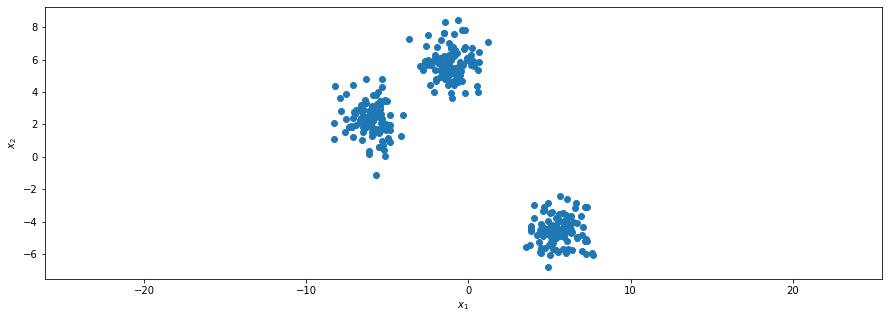

+----------------------------------------+
|features                                |
+----------------------------------------+
|[5.585237373748507,-4.794868701166052]  |
|[-5.0195752677023355,3.434121443139315] |
|[-7.904959866892547,3.652559125701152]  |
|[0.03748802701681253,5.9775096000147565]|
|[5.0112894340875505,-4.522206180823035] |
|[5.216151582225241,-5.329963982420278]  |
|[-0.8822678723132585,7.600851499827227] |
|[4.69635712537919,-5.645425956766199]   |
|[-1.462990700348187,8.344962884979248]  |
|[-5.37217557299428,2.0623646367492583]  |
|[5.6284606607771925,-2.444070527717862] |
|[-7.029279292403895,2.6681609075303925] |
|[-6.489814874663033,1.5259765595300965] |
|[5.434186685858791,-4.429033911748826]  |
|[-1.633331451824887,5.620064704311385]  |
|[-7.579042732344923,3.8651613735688803] |
|[5.198871960316093,-5.685209432556292]  |
|[-2.5110457574589216,7.495151306731135] |
|[-5.3286021974907625,0.996365343752331] |
|[4.83347627885324,-4.44826581784454]    |
+----------

In [57]:
from sklearn.datasets import make_blobs
from pyspark.ml.linalg import Vectors

data = make_blobs(n_samples=300, random_state=1234)[0]

plt.scatter(data[:,0], data[:,1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.show()

blobs = spark.createDataFrame([[Vectors.dense(v)] for v in data], ["features"])

blobs.show(truncate=False)

* El DataFrame ya tiene una única columna de características.
* Aunque el problema es no supervisado, se puede dividir el conjunto de datos en entrenamiento ($70\%$) y test ($30\%$) para mostrar cómo se asignan puntos nuevos al grupo que corresponda.

In [58]:
blobs_tr, blobs_te = blobs.randomSplit([0.7, 0.3], seed=1234)

blobs_tr.show(truncate=False)

+---------------------------------------+
|features                               |
+---------------------------------------+
|[-8.254876634542264,4.372422188262213] |
|[-7.904959866892547,3.652559125701152] |
|[-7.642727405887801,1.5455948054947664]|
|[-7.579042732344923,3.8651613735688803]|
|[-7.571584273922998,2.3412572208477234]|
|[-7.365134734089125,1.8503124476493884]|
|[-7.238599775902286,1.9302941116698222]|
|[-7.19746155110406,1.857457209535849]  |
|[-7.143847326189469,2.3718305436925347]|
|[-7.107763606515258,1.2031038582018447]|
|[-7.09586530595238,4.450018371574638]  |
|[-7.056330344907532,2.7763733516956464]|
|[-7.029279292403895,2.6681609075303925]|
|[-6.955046204185351,2.904235157958686] |
|[-6.950716276047546,1.9741577544591518]|
|[-6.852494988871488,2.878433025137554] |
|[-6.717853441609009,2.297555912427253] |
|[-6.648934995997651,2.143159127830557] |
|[-6.620376095558428,3.1913392267157024]|
|[-6.584115835954344,1.0163806873586159]|
+---------------------------------

## Entrenamiento en clustering

* Para construir un modelo de *clustering*, se usan los Estimators del módulo [`ml.clustering`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#clustering).

El siguiente código entrena un modelo de $k$-means.
De nuevo, primero se crea el Estimator, y luego se utiliza el método `fit()` para obtener el modelo adaptado a los datos (en este caso, con los centroides calculados).

In [59]:
from pyspark.ml.clustering import KMeans

# Estimator.
kmeans_es = KMeans(k=3)
# Transformer.
kmeans_tr = kmeans_es.fit(blobs_tr)

print(kmeans_tr)

KMeansModel: uid=KMeans_23a6ecd15311, k=3, distanceMeasure=euclidean, numFeatures=2


## Predicción en clustering

* Tras adaptarlo a los datos, los modelos son objetos Transformer que pueden realizar asignaciones de grupo sobre un DataFrame con nuevos puntos.
* Al realizar la predicción sobre un conjunto de datos usando el modelo de $k$-means aparece una nueva columna:
    * `prediction`: Contiene el grupo asignado.

A continuación se realiza la predicción sobre el conjunto de test.

In [60]:
pred_kmeans = kmeans_tr.transform(blobs_te)

pred_kmeans.select("prediction").show()

+----------+
|prediction|
+----------+
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
+----------+
only showing top 20 rows



Como este ejemplo es muy sencillo, se puede visualizar el resultado.

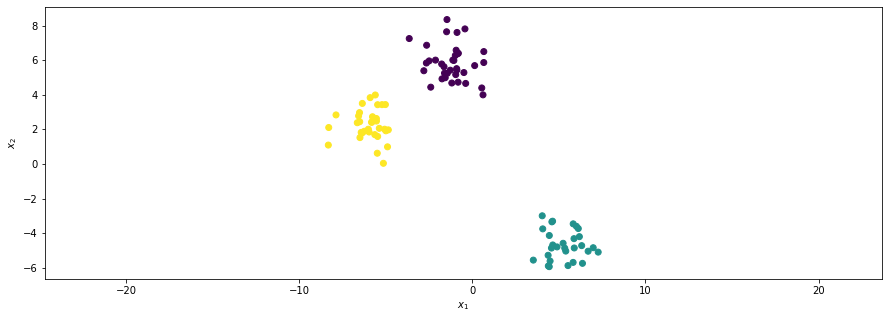

In [61]:
data = pred_kmeans.collect()
features = np.array([row["features"].toArray() for row in data])
prediction = np.array([row["prediction"] for row in data])

plt.scatter(features[:,0], features[:,1], c=prediction)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.show()

## Evaluación en clustering

* Para evaluar los modelos de *clustering* se puede usar de nuevo el módulo [`ml.evaluation`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#evaluation), en concreto el siguiente Evaluator:
    * [`ml.evaluation.ClusteringEvaluator`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.ClusteringEvaluator.html), para problemas de *clustering*, que permite calcular la siguiente métrica:
        * `"silhouette"` (por defecto), calcula el coeficiente Silhouette (entre $-1$ y $1$, mejor cuanto mayor).

La siguiente celda muestra un ejemplo de cómo calcular la medida anterior para *clustering*, con las agrupaciones del modelo de $k$-means.

In [62]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()

print("Sil (k=3): %.2f" % evaluator.evaluate(pred_kmeans))

Sil (k=3): 0.92


El resultado anterior se puede comparar con otros agrupamientos con distinto número de clases.

In [63]:
for k in [2, 4, 5]:
    print("Sil (k=%d): %.2f" % (k, evaluator.evaluate(KMeans(k=k).fit(boston_tr).transform(boston_te))))

Sil (k=2): 0.84
Sil (k=4): 0.74
Sil (k=5): 0.61


## Persistencia en modelos de clustering

En la siguiente celda se puede ver un ejemplo de cómo se guarda el modelo de $k$-means adaptado anteriormente, y cómo se puede cargar y utilizar para asignar nuevos puntos posteriormente.

In [64]:
from pyspark.ml.clustering import KMeansModel

kmeans_tr.save("./Model_kmeans")

loaded = KMeansModel.load("./Model_kmeans")

print(loaded)
print("")
loaded.transform(blobs_te).select("prediction").show()

KMeansModel: uid=KMeans_23a6ecd15311, k=3, distanceMeasure=euclidean, numFeatures=2

+----------+
|prediction|
+----------+
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
+----------+
only showing top 20 rows



## Ejercicio de clustering

<div class="qst">

* Repetir la metodología para problemas de *clustering* utilizando un modelo de $k$-means por bisección (*bisecting $k$-means*). Para ello:
    * Entrenar un modelo de $k$-means por bisección utilizando el conjunto de datos `blobs_tr`, y almacenar el modelo en un Transformer con nombre `bkmeans_tr`.
    * Predecir sobre el conjunto de datos `blobs_te` usando el modelo de $k$-means por bisección, y almacenar el resultado en un DataFrame con nombre `pred_bkmeans`.
    * Calcular e imprimir la medida de calidad en el caso del modelo de $k$-means por bisección, y comparar con el resultados de $k$-means.
    * Almacenar el modelo de $k$-means por bisección entrenado en el directorio `./Model_bkmeans`.
    * Comprobar que el modelo almacenado se puede cargar, y sigue realizando correctamente las predicciones.

</div>

In [65]:
from pyspark.ml.clustering import BisectingKMeans, BisectingKMeansModel

################################
# Insertar código.
# Estimator.
bkmeans_es = BisectingKMeans(k=3)
# Transformer.
bkmeans_tr = bkmeans_es.fit(blobs_tr)
# Predicción.
pred_bkmeans = bkmeans_tr.transform(blobs_te)
# Evaluación.
evaluator = ClusteringEvaluator()
print("Sil (k=3): %.2f" % evaluator.evaluate(pred_bkmeans))
# Almacenamiento.
bkmeans_tr.save("./Model_bkmeans")
# Recuperación.
loaded = BisectingKMeansModel.load("./Model_bkmeans")

pred_bkmeans.select("prediction").show()
loaded.transform(blobs_te).select("prediction").show()
################################

Sil (k=3): 0.92
+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 20 rows

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 20 rows



# Pipelines

## Introducción a los Pipelines

* Cuando se resuelve un problema de ML es muy común tener que realizar una secuencia de varios pasos para transformar los datos originales en predicciones.
* Esta secuencia deberá ser igual en entrenamiento (cuando se usan los Estimators) y en predicción (cuando se aplican los Transformers).
* Para facilitar la construcción de estos flujos de trabajo en Spark se usan los Pipelines.
    * Básicamente, un Pipeline es una secuencia de Transformers y Estimators, que se aplicarán por orden sobre un DataFrame.
    * Una vez construido, el Pipeline tiene una función `fit()` que llama de forma secuencial a la función `fit()` de los Estimators, a la vez que va transformando el DataFrame en cada nivel para usarlo como entrada del siguiente paso.
* La propia documentación de MLlib trae un ejemplo muy ilustrativo en un problema de clasificación de textos.
    * En concreto, el Pipeline durante la fase de entrenamiento se corresponde al esquema que se muestra a continuación, donde los elementos en azul representan Transformers y los elementos en rojo representan Estimators:
<img src="figures/ml-Pipeline.png" width="690" alt="Pipeline durante la fase de entrenamiento.">
    * Una vez realizada la llamada a `fit()` se obtiene un modelo en forma de Transformer, que se puede utilizar para realizar nuevas predicciones, para lo que aplicará por orden cada uno de los pasos especificados en el Pipeline, como se muestra a continuación:
<img src="figures/ml-PipelineModel.png" width="695" alt="Pipeline durante la fase de predicción.">

## Conjunto de datos para Pipelines

* Como ilustración se usará un sencillo problema sintético de clasificación de textos.
    * La clase positiva son aquellos textos que tratan sobre Spark.

In [66]:
# Preparar los datos a partir de una lista de tuplas (text, label).
texts = spark.createDataFrame([
    ["a b c d e spark", 1],
    ["b d", 0],
    ["spark f g h", 1],
    ["hadoop mapreduce", 0],
    ["spark i j k", 1],
    ["l m n", 0],
    ["spark hadoop spark", 1],
    ["apache hadoop", 0]
], ["text", "label"])

texts.show()

+------------------+-----+
|              text|label|
+------------------+-----+
|   a b c d e spark|    1|
|               b d|    0|
|       spark f g h|    1|
|  hadoop mapreduce|    0|
|       spark i j k|    1|
|             l m n|    0|
|spark hadoop spark|    1|
|     apache hadoop|    0|
+------------------+-----+



* El conjunto de datos se divide en entrenamiento ($50\%$) y test ($50\%$).

In [67]:
texts_tr, texts_te = texts.randomSplit([0.5, 0.5], seed=1234)

texts_tr.show()
texts_te.show()

+----------------+-----+
|            text|label|
+----------------+-----+
|             b d|    0|
|hadoop mapreduce|    0|
|     spark f g h|    1|
|     spark i j k|    1|
+----------------+-----+

+------------------+-----+
|              text|label|
+------------------+-----+
|   a b c d e spark|    1|
|     apache hadoop|    0|
|             l m n|    0|
|spark hadoop spark|    1|
+------------------+-----+



## Entrenamiento con Pipelines

* Los Pipelines de Spark están implementados en la clase [`ml.pipeline`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html).
* Para construir un Pipeline, primero hay que crear los objetos Transformer y Estimator que lo compondrán, y a continuación crear el objeto Pipeline indicando en el argumento `stages` las distintas fases que formarán parte del flujo de trabajo.

En la siguiente celda se crea el Pipeline descrito arriba para clasificación de textos.

In [68]:
from pyspark.ml.feature import Tokenizer, HashingTF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.pipeline import Pipeline

tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashing = HashingTF(inputCol="words", outputCol="features")
logreg_es = LogisticRegression(maxIter=10, regParam=0.001)

# Estimator.
pipeline_es = Pipeline(stages=[tokenizer, hashing, logreg_es])
# Transformer.
pipeline_tr = pipeline_es.fit(texts_tr)

print(pipeline_tr)

PipelineModel_64205af0ad60


## Predicción con Pipelines

* Tras el entrenamiento, todo el Pipeline se ha convertido en un Transformer que se puede utilizar para realizar predicciones sobre un DataFrame con nuevos puntos, aplicando una a una las transformaciones definidas en el Pipeline.

In [69]:
pred_pipeline = pipeline_tr.transform(texts_te)

pred_pipeline.show(vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------
 text          | a b c d e spark                                                              
 label         | 1                                                                            
 words         | [a, b, c, d, e, spark]                                                       
 features      | (262144,[74920,89530,107107,148981,167694,173558],[1.0,1.0,1.0,1.0,1.0,1.0]) 
 rawPrediction | [3.649619461045998,-3.649619461045998]                                       
 probability   | [0.974657899204672,0.02534210079532795]                                      
 prediction    | 0.0                                                                          
-RECORD 1-------------------------------------------------------------------------------------
 text          | apache hadoop                                                                
 label         | 0                                

## Persistencia con Pipelines

* En cuanto a persistencia, los Pipelines se comportan como cualquier otro modelo de MLlib, pueden almacenarse en disco para ser cargados cuando sea necesario realizar nuevas predicciones.

En la siguiente celda se almacena y recupera el Pipeline creado anteriormente.

In [70]:
from pyspark.ml.pipeline import PipelineModel

pipeline_tr.save("./Model_pipeline")

loaded = PipelineModel.load("./Model_pipeline")

print(loaded)
print("")
loaded.transform(texts_te).select("prediction").show()

PipelineModel_64205af0ad60

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       1.0|
+----------+



## Ejercicio de Pipelines

A continuación se define un problema de regresión 1-dimensional.

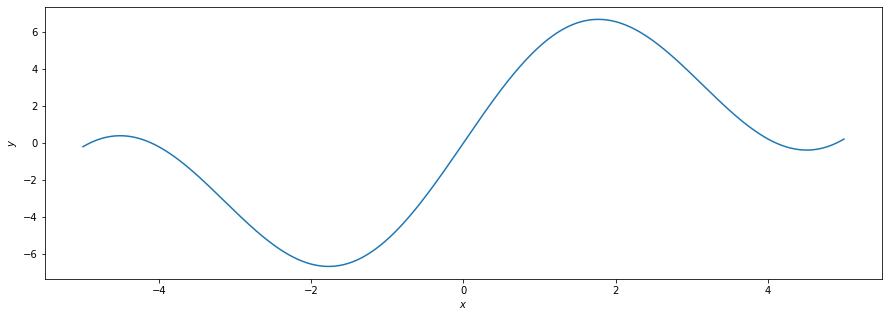

+--------------------+--------------------+
|                   x|               label|
+--------------------+--------------------+
|[-4.959919839679359]|-0.11231812610382885|
|[-4.939879759519038]|-0.06870288366074906|
|[-4.8997995991983...| 0.01265025142429721|
|[-4.8797595190380...|0.050371569195680976|
|[-4.859719438877756]| 0.08611298885685414|
|[-4.839679358717435]| 0.11986820488533478|
|[-4.819639278557114]| 0.15163170940088389|
|[-4.799599198396794]|  0.1813987943774258|
|[-4.779559118236473]| 0.20916555353374822|
|[-4.759519038076152]|   0.234928883902227|
|[-4.739478957915832]| 0.25868648707495456|
|[-4.719438877755511]|  0.2804368701267643|
| [-4.69939879759519]|  0.3001793462147697|
|[-4.679358717434869]| 0.31791403485419956|
|[-4.659318637274549]| 0.33364186187039646|
|[-4.6392785571142...|  0.3473645590270218|
|[-4.619238476953908]|  0.3590846633305853|
|[-4.599198396793588]|  0.3688055160116104|
|[-4.559118236472946]| 0.38226684417491263|
|[-4.539078156312625]|  0.386018

In [71]:
from pyspark.ml.linalg import Vectors

x = np.linspace(-5, 5, 500)
y = 5 * np.sin(x) + x

plt.plot(x, y, "-")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

sine = spark.createDataFrame([[Vectors.dense(u), v] for u, v in zip(x.tolist(), y.tolist())], ["x", "label"])
sine_tr, sine_te = sine.randomSplit([0.7, 0.3], seed=1234)

sine_tr.show()

<div class="qst">

* Dado el problema de regresión definido arriba, crear un Transformer de nombre `pipeline_tr` que contenga el modelo correspondiente a un Pipeline entrenado sobre el DataFrame `sine_tr`. El Pipeline deberá tener los siguientes pasos:
    * Una expansión polinómica de grado $5$.
    * Un escalado estándar de los datos (en media y desviación).
    * Un modelo de regresión lineal con los parámetros por defecto.
* Utilizar el Transformer anterior para predecir sobre el DataFrame `sine_te`, almacenando el resultado en un nuevo DataFrame `pred_pipeline`.

</div>

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   x|               label|              x_poly|            features|          prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|              [-5.0]|-0.20537862668430762|[-5.0,25.0,-125.0...|[-1.7573166016326...| -1.3855059635755347|
|[-4.979959919839679]|-0.15788012357227998|[-4.9799599198396...|[-1.7503336154279...|  -1.216608854438436|
|[-4.919839679358717]|-0.02704386382482...|[-4.9198396793587...|[-1.7293846568137...| -0.7560615717509857|
|[-4.579158316633267]|  0.3765312611828229|[-4.5791583166332...|[-1.6106738913338...|  0.7146895856269045|
|[-4.519038076152305]|  0.3877912987973202|[-4.5190380761523...|[-1.5897249327197...|  0.8038858492793656|
|[-4.498997995991984]|  0.3875940477009152|[-4.4989979959919...|[-1.5827419465149...|  0.8240145554981643|
|[-4.478957915831663]| 0.385434383398

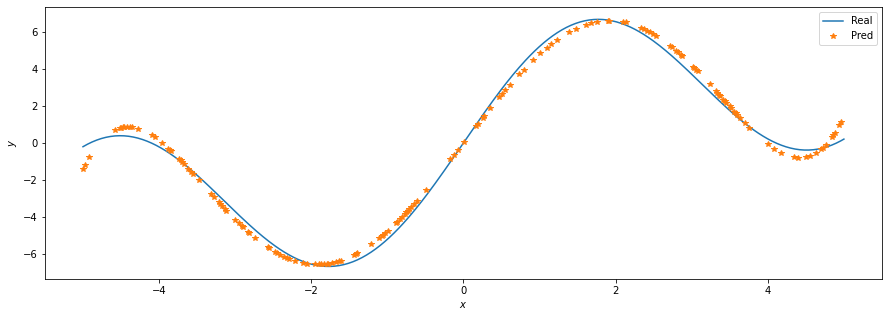

In [72]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import PolynomialExpansion, StandardScaler
from pyspark.ml.pipeline import Pipeline

################################
# Insertar código.
poly_tr = PolynomialExpansion(degree=5, inputCol="x", outputCol="x_poly")
scaler_es = StandardScaler(withMean=True, withStd=True, inputCol="x_poly", outputCol="features")
linreg_es = LinearRegression()

# Estimator.
pipeline_es = Pipeline(stages=[poly_tr, scaler_es, linreg_es])
# Transformer.
pipeline_tr = pipeline_es.fit(sine_tr)

# Predicción.
pred_pipeline = pipeline_tr.transform(sine_te)
################################

pred_pipeline.show()

data = pred_pipeline.collect()
x_p = np.array([row["x"].toArray() for row in data])
y_p = np.array([row["prediction"] for row in data])

plt.plot(x, y, "-", label="Real")
plt.plot(x_p, y_p, "*", label="Pred")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

# Ajuste de hiperparámetros

## Introducción al ajuste de hiperparámetros

* Cuando se afronta un problema de ML, y una vez que se ha decidido el modelo que se va a utilizar, es crucial determinar los mejores **hiperparámetros** (aquellos parámetros del modelo que hay que fijar de antemano, ya que no se ajustan durante el entrenamiento).
* Una de las aproximaciones más comunes para ajustar los hiperparámetros es utilizar uno o varios conjuntos de validación donde se estimará la precisión que tendrá el modelo en test.
* MLlib soporta dos métodos de validación, definidos en el módulo [`ml.tuning`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#tuning) a través de los siguientes objetos:
    * [`ml.tuning.CrossValidator`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html), que ajusta los hiperparámetros usando validación cruzada.
    * [`ml.tuning.TrainValidationSplit`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.TrainValidationSplit.html), que ajusta los hiperparámetros usando una única partición de entrenamiento/validación.
* Cualquiera de los dos métodos necesita los siguientes elementos:
    * El Estimator (puede ser un Pipeline) cuyos hiperparámetros se van a ajustar.
    * Un conjunto de valores posibles para los hiperparámetros. A menudo se realiza una búsqueda en rejilla (*grid*), y se construye usando la clase [`ml.tuning.ParamGridBuilder`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html).
    * Un Evaluator que establece la medida de lo bien que funciona el modelo entrenado con los distintos hiperparámetros.
* Ambos métodos devuelven un Estimator, que cuando se ajusta a los datos (usando la función `fit()`) realiza las siguientes operaciones:
    1. El conjunto de datos se divide en dos (entrenamiento y validación), una o varias veces según el método usado.
    2. El conjunto de entrenamiento se utiliza para entrenar modelos con cada uno de los posibles conjuntos de valores de los hiperparámetros.
    3. Cada uno de estos modelos se evalúa sobre el conjunto de validación.
    4. Los hiperparámetros del modelo que da los mejores resultados (de acuerdo al Evaluator) son seleccionados.
    5. Se devuelve un modelo final entrenado con todos los datos disponibles y usando los mejores hiperparámetros.
* Por tanto, el resultado de entrenar estos objetos de validación, que no son más que Estimators, es un Transformer entrenado con los hiperparámetros óptimos, que se podrá usar para realizar predicciones sobre nuevos datos.

## Conjunto de datos para el ajuste de hiperparámetros

Se usará de nuevo el dataset *boston*, definido más arriba.

In [73]:
boston_tr.show()

+-------+-----+-----+----+------+-----+----+-------+---+-----+-------+------+-----+-----+--------------------+
|   CRIM|   ZN|INDUS|CHAS|   NOX|   RM| AGE|    DIS|RAD|  TAX|PTRATIO|     B|LSTAT|label|            features|
+-------+-----+-----+----+------+-----+----+-------+---+-----+-------+------+-----+-----+--------------------+
|0.01096| 55.0| 2.25| 0.0| 0.389|6.453|31.9| 7.3073|1.0|300.0|   15.3|394.72| 8.23| 22.0|[0.01096,55.0,2.2...|
|0.01301| 35.0| 1.52| 0.0| 0.442|7.241|49.3| 7.0379|1.0|284.0|   15.5|394.74| 5.49| 32.7|[0.01301,35.0,1.5...|
| 0.0136| 75.0|  4.0| 0.0|  0.41|5.888|47.6| 7.3197|3.0|469.0|   21.1| 396.9| 14.8| 18.9|[0.0136,75.0,4.0,...|
|0.01381| 80.0| 0.46| 0.0| 0.422|7.875|32.0| 5.6484|4.0|255.0|   14.4|394.23| 2.97| 50.0|[0.01381,80.0,0.4...|
|0.01432|100.0| 1.32| 0.0| 0.411|6.816|40.5| 8.3248|5.0|256.0|   15.1| 392.9| 3.95| 31.6|[0.01432,100.0,1....|
|0.01439| 60.0| 2.93| 0.0| 0.401|6.604|18.8| 6.2196|1.0|265.0|   15.6| 376.7| 4.38| 29.1|[0.01439,60.0,2.9...|
|

## Construcción de la rejilla

* El primer paso para seleccionar los hiperparámetros es crear el espacio de búsqueda.

En el siguiente ejemplo se crea una rejilla de dos dimensiones para un modelo de bosque aleatorio de regresión, donde el hiperparámetro `numTrees` tomará tres posibles valores, y el hiperparámetro `maxDepth` tomará otros tres.
El número total de configuraciones que se evaluarán será, por tanto de $3 \times 3 = 9$.

In [74]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder

# Modelo que se va a ajustar.
ranforr = RandomForestRegressor()

# Rejilla.
paramGrid = ParamGridBuilder()\
    .addGrid(ranforr.numTrees, [15, 20, 25]) \
    .addGrid(ranforr.maxDepth, [4, 5, 6])\
    .build()

## Ajuste de hiperparámetros

* Para realizar el ajuste de hiperparámetros, es necesario crear el objeto de validación, y simplemente llamar a la función `fit()` como con cualquier otro Estimator.

A continuación, se crea un objeto CrossValidator para optimizar un bosque aleatorio de regresión, usando el coeficiente $R^2$, la rejilla definida anteriormente, y $3$ hojas para la validación cruzada.
Por tanto, se tendrán que construir y evaluar $9 \times 3 = 27$ modelos diferentes.

In [75]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Estimator.
cv_es = CrossValidator(estimator=ranforr,
                       estimatorParamMaps=paramGrid,
                       evaluator=RegressionEvaluator(metricName="r2"),
                       numFolds=3,
                       seed=1234
                      )

# Transformer.
cv_tr = cv_es.fit(boston_tr)

La siguiente celda muestra los hiperparámetros óptimos encontrados.

In [76]:
for param, value in cv_tr.getEstimatorParamMaps()[np.argmax(cv_tr.avgMetrics)].items():
    print("%-10s %5g" % (param.name + ":", value))

numTrees:     25
maxDepth:      6


## Predicción con ajuste de hiperparámetros

* A la hora de predecir, y dado que el resultado de la validación es un Transformer, basta con aplicar la función `transform()` a los datos nuevos.

In [77]:
pred_cv = cv_tr.transform(boston_te)

pred_cv.select("prediction").show()

+------------------+
|        prediction|
+------------------+
| 28.55145820314544|
| 30.76990639383803|
| 35.37168373585479|
|24.903288108525363|
|22.645209855285692|
|29.116682217799404|
|24.218988067915564|
|26.616132037692992|
|20.302863963723457|
| 20.91491648809866|
| 32.99569877451983|
|20.342248579108073|
|26.631315307877852|
|23.256204810384205|
| 24.10892848484116|
|  22.7862335327418|
| 20.96578892561854|
|24.463811239990243|
|24.928381035603916|
| 18.78842744546201|
+------------------+
only showing top 20 rows



Se puede comparar el resultado en test de este modelo con el bosque aleatorio con parámetros por defecto utilizado antes, para ver si se ha producido alguna mejora.

In [78]:
evaluator = RegressionEvaluator()

print("R2 (default): {:5.3f}".format(evaluator.evaluate(pred_ranforr, {evaluator.metricName: "r2"})))
print("R2 (tuned):   {:5.3f}".format(evaluator.evaluate(pred_cv, {evaluator.metricName: "r2"})))

R2 (default): 0.809
R2 (tuned):   0.814


## Persistencia de modelos ajustados

* En cuanto a persistencia, como el resultado de la validación es un modelo de MLlib, se puede almacenar en disco de la forma usual.

En la siguiente celda se almacena y recupera el modelo con hiperparámetros óptimos creado anteriormente.

In [79]:
from pyspark.ml.tuning import CrossValidatorModel

cv_tr.save("./Model_cv")

loaded = CrossValidatorModel.load("./Model_cv")

print(loaded)
print("")
loaded.transform(boston_te).select("prediction").show()

CrossValidatorModel_20c7839a2a76

+------------------+
|        prediction|
+------------------+
| 28.55145820314544|
| 30.76990639383803|
| 35.37168373585479|
|24.903288108525363|
|22.645209855285692|
|29.116682217799404|
|24.218988067915564|
|26.616132037692992|
|20.302863963723457|
| 20.91491648809866|
| 32.99569877451983|
|20.342248579108073|
|26.631315307877852|
|23.256204810384205|
| 24.10892848484116|
|  22.7862335327418|
| 20.96578892561854|
|24.463811239990243|
|24.928381035603916|
| 18.78842744546201|
+------------------+
only showing top 20 rows



## Ejercicio de ajuste de hiperparámetros

<div class="qst">

* Partiendo del Pipeline del último ejercicio, ajustar el hiperparámetro `degree` de la expansión polinómica de manera que tome los valores $(3, 5, 7)$, y el hiperparámetro `regParam` de la regresión lineal de manera que tome los valores $(0, 0.01, 0.1)$. Utilizar para ello el DataFrame `sine_tr`, y almacenar el Transformer resultante en la variable `cv_tr`.
* Utilizar el Transformer anterior para predecir sobre el DataFrame `sine_te`, almacenando el resultado en un nuevo DataFrame `pred_cv`.

<div class="notes">

* Para definir una rejilla con un Pipeline se pueden usar los Estimators y Transformers que lo van a componer, por ejemplo, `poly_tr.degree` se refiere al hiperparámetro `degree` de la componente `poly_tr`.

</div>
</div>

R2 (default): 0.9913
R2 (tuning):  0.9999


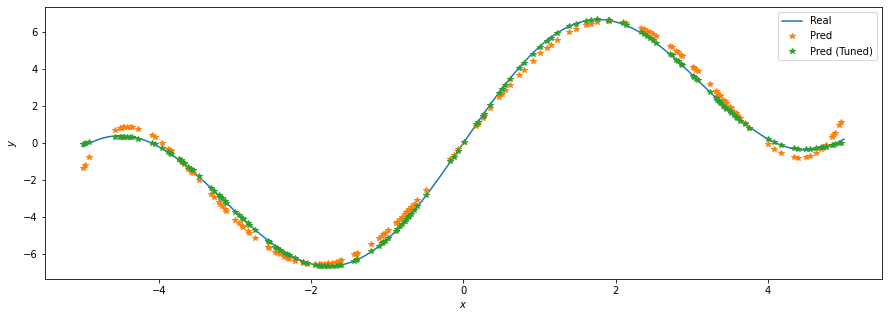

In [80]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import PolynomialExpansion, StandardScaler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

################################
# Insertar código.
# Modelos base.
poly_tr = PolynomialExpansion(inputCol="x", outputCol="x_poly")
scaler_es = StandardScaler(withMean=True, withStd=True, inputCol="x_poly", outputCol="features")
linreg_es = LinearRegression()

# Rejilla.
paramGrid = ParamGridBuilder()\
    .addGrid(poly_tr.degree, [3, 5, 7]) \
    .addGrid(linreg_es.regParam, [0, 0.01, 0.1])\
    .build()

# Pipeline.
pipeline_es = Pipeline(stages=[poly_tr, scaler_es, linreg_es])

# Estimator.
cv_es = CrossValidator(estimator=pipeline_es,
                       estimatorParamMaps=paramGrid,
                       evaluator=RegressionEvaluator(metricName="r2"),
                       numFolds=3,
                       seed=1234
                      )

# Transformer.
cv_tr = cv_es.fit(sine_tr)

# Predicción.
pred_cv = cv_tr.transform(sine_te)
################################

evaluator = RegressionEvaluator()

print("R2 (default): {:.4f}".format(evaluator.evaluate(pred_pipeline, {evaluator.metricName: "r2"})))
print("R2 (tuning):  {:.4f}".format(evaluator.evaluate(pred_cv, {evaluator.metricName: "r2"})))

data = pred_pipeline.collect()
x_ps = np.array([row["x"].toArray() for row in data])
y_ps = np.array([row["prediction"] for row in data])

data = pred_cv.collect()
x_pt = np.array([row["x"].toArray() for row in data])
y_pt = np.array([row["prediction"] for row in data])

plt.plot(x, y, "-", label="Real")
plt.plot(x_ps, y_ps, "*", label="Pred")
plt.plot(x_pt, y_pt, "*", label="Pred (Tuned)")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

# Ejemplo de uso

A continuación se muestran distintos ejemplos de uso de Spark MLlib, incluyendo primero la parte de análisis exploratorio e integración con Pandas y Matplotlib, para posteriormente ajustar un algoritmo de aprendizaje automático.

## Conjunto de datos Adult

El conjunto de datos que se va a utilizar es [*Adult*](http://archive.ics.uci.edu/ml/datasets/Adult), perteneciente al repositorio UCI, formado por una muestra de individuos con diferentes atributos y cuyo objetivo consiste en predecir si su salario está por encima o por debajo de $50.000$$ dólares al año.

La siguiente celda carga el conjunto de datos, mostrando su estructura y el número total de patrones.

In [81]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

adult = spark.\
    read.\
    option("header", "true").\
    option("inferschema", "true").\
    option("mode", "DROPMALFORMED").\
    csv("./data/adult.csv").\
    cache()

adult.printSchema()

print("Number of samples: %d" % adult.count())

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- target: integer (nullable = true)

Number of samples: 32561


Una vez cargados los datos, se pueden realizar consultas para realizar una inspección preliminar.

<div class="qst">

* Sacar el número de patrones de cada una de las categorías correspondientes a la columna `"workclass"`.

<div class="notes">

* Se recomienda utilizar el método de agregación `groupBy()`.

</div>
</div>

In [82]:
################################
# Insertar código.
adult.groupBy("workclass").count().show()
################################

+----------------+-----+
|       workclass|count|
+----------------+-----+
|Self-emp-not-inc| 2541|
|            null| 1836|
|       Local-gov| 2093|
|       State-gov| 1298|
|         Private|22696|
|     Without-pay|   14|
|     Federal-gov|  960|
|    Never-worked|    7|
|    Self-emp-inc| 1116|
+----------------+-----+



Se puede obtener un pequeño resumen de algunas características (en este caso las $5$ primeras) mediante los métodos `describe()` o `summary()`, aunque solo funcionará con características numéricas.

In [83]:
print("Description:")
adult.select(adult.columns[:5]).describe().show()

print("Summary:")
adult.select(adult.columns[:5]).summary().show()

Description:
+-------+------------------+-----------+------------------+------------+-----------------+
|summary|               age|  workclass|            fnlwgt|   education|    education_num|
+-------+------------------+-----------+------------------+------------+-----------------+
|  count|             32561|      30725|             32561|       32561|            32561|
|   mean| 38.58164675532078|       null|189778.36651208502|        null| 10.0806793403151|
| stddev|13.640432553581356|       null|105549.97769702227|        null|2.572720332067397|
|    min|                17|Federal-gov|             12285|        10th|                1|
|    max|                90|Without-pay|           1484705|Some-college|               16|
+-------+------------------+-----------+------------------+------------+-----------------+

Summary:
+-------+------------------+-----------+------------------+------------+-----------------+
|summary|               age|  workclass|            fnlwgt|   educa

Con el objetivo de realizar una primera limpieza de los datos, se eliminan las columnas que tienen campos vacíos (a `null`), o aquellas columnas que son constantes.

In [84]:
from pyspark.sql import Column

not_valid = []

for field in adult.columns:
    count = adult.filter(field + " is null").count()
    count_distinct = adult.select(field).distinct().count()

    if (count > 0) or (count_distinct == 1):
        not_valid.append(field)

    print("%-20s\tMissing values: %5d\tDistinc values: %5d" % (field, count, count_distinct))

print("\nDropping:", *not_valid, end="\n\n")
adult = adult.drop(*not_valid)

adult.printSchema()

age                 	Missing values:     0	Distinc values:    73
workclass           	Missing values:  1836	Distinc values:     9
fnlwgt              	Missing values:     0	Distinc values: 21648
education           	Missing values:     0	Distinc values:    16
education_num       	Missing values:     0	Distinc values:    16
marital_status      	Missing values:     0	Distinc values:     7
occupation          	Missing values:  1843	Distinc values:    15
relationship        	Missing values:     0	Distinc values:     6
race                	Missing values:     0	Distinc values:     5
sex                 	Missing values:     0	Distinc values:     2
capital_gain        	Missing values:     0	Distinc values:   119
capital_loss        	Missing values:     0	Distinc values:    92
hours_per_week      	Missing values:     0	Distinc values:    94
native_country      	Missing values:   583	Distinc values:    42
target              	Missing values:     0	Distinc values:     2

Dropping: workclass occu

Para hacerlo más manejable, se reduce el conjunto de datos reteniendo solo aquellos individuos con menos de $35$ años.

Además, se renombra la columna de las etiquetas para hacer más sencillas las llamadas cuando se construyan los modelos.

In [85]:
print("Number of samples (old): %d" % adult.count())
adult = adult.filter(adult.age < 35).withColumnRenamed("target", "label")
print("Number of samples (new): %d" % adult.count())

Number of samples (old): 32561
Number of samples (new): 14049


## Análisis de los datos de Adult

### Histograma de edades

La siguiente celda muestra como generar un histograma de la columna `"age"`.

El histograma se calcula a partir del RDD, de manera que la parte computacionalmente costosa se hace desde Spark, pero la figura se representa localmente.

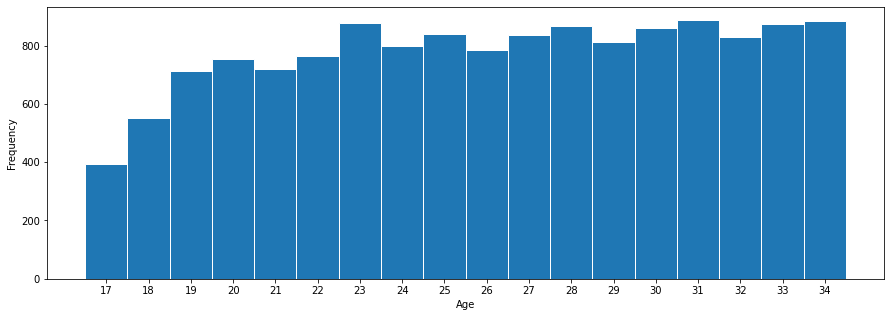

In [86]:
import numpy as np
from matplotlib import pyplot as plt

hist = adult.select("age").rdd.map(lambda row: row["age"]).histogram(np.linspace(16.5, 34.5, 19).tolist())

bins = np.array(hist[0])
bins = (bins[1:] + bins[:-1]) / 2
freqs = np.array(hist[1])

plt.bar(bins, freqs, width=(bins[1] - bins[0]), edgecolor="white")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xticks(bins)
plt.show()

### Porcentaje por estado civil

En el siguiente ejemplo se muestra el porcentaje de ejemplos según el valor del atributo `"marital_status"`.

De nuevo, los porcentajes se calculan de manera distribuida y solo se descarga localmente el resultado para pintarlo.

In [87]:
from pyspark.sql.functions import col, lit

num_samples = adult.count()
mstatus = adult.groupBy("marital_status").count().sort(col("count"))
mstatus = mstatus.withColumn("ratio", col("count") / num_samples)
mstatus.show()

mstatus_pd = mstatus.toPandas()
display(mstatus_pd)

+--------------------+-----+--------------------+
|      marital_status|count|               ratio|
+--------------------+-----+--------------------+
|   Married-AF-spouse|   16|0.001138871094028...|
|             Widowed|   29|0.002064203857925831|
|Married-spouse-ab...|  150|0.010676916506512918|
|           Separated|  373|0.026549932379528792|
|            Divorced|  970|  0.0690440600754502|
|  Married-civ-spouse| 3975| 0.28293828742259236|
|       Never-married| 8536|  0.6075877286639618|
+--------------------+-----+--------------------+



,marital_status,count,ratio
0,Married-AF-spouse,16,0.001139
1,Widowed,29,0.002064
2,Married-spouse-absent,150,0.010677
3,Separated,373,0.026550
4,Divorced,970,0.069044
5,Married-civ-spouse,3975,0.282938
6,Never-married,8536,0.607588


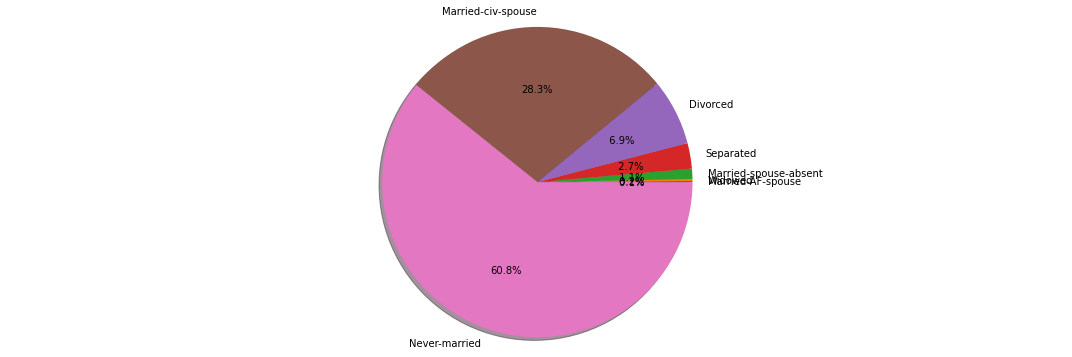

In [88]:
labs = mstatus_pd["marital_status"]
sizs = mstatus_pd["ratio"]

plt.pie(sizs, labels=labs, autopct='%4.1f%%', shadow=True)
plt.axis('equal')
plt.tight_layout()
plt.show()  

## Preproceso de Adult

Es importante, para tener éxito en la tarea de predicción, realizar un adecuado preproceso de los datos.

En primer lugar, se divide el conjunto de datos en una parte para entrenamiento y otra para test.

In [89]:
adult_tr, adult_te = adult.randomSplit([0.7, 0.3], seed=1234)

### StringIndexers

El primer paso para el preproceso consiste en convertir las variables categóricas en variables numéricas, para lo que habrá que utilizar primero un conjunto de StringIndexers, que formarán parte del Pipeline.

En la siguiente celda, se identifican las columnas categóricas como aquellas de tipo `"string"`.

In [90]:
fields_str = []
for field, field_type in adult_tr.dtypes:
    if (field_type == "string"):
        fields_str.append(field)

print("String fields:", fields_str)

String fields: ['education', 'marital_status', 'relationship', 'race', 'sex']


<div class="qst">

* Crear una lista de StringIndexers de nombre `indexers`, cada uno de los cuales tomará uno de los atributos de tipo `string`, y creará un nuevo atributo numérico, cuyo nombre sea el nombre original con el sufijo `"_ind"`.
* Crear un Pipeline que realice todas las transformaciones, y comprobar con el conjunto `adult_tr` que añade las columnas adecuadamente.

</div>

In [91]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

################################
# Insertar código.
indexers = []
for field in fields_str:
    indexers.append(StringIndexer(inputCol=field, outputCol=field + "_ind"))

Pipeline(stages=indexers).fit(adult_tr).transform(adult_tr).printSchema()
################################

root
 |-- age: integer (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- education_ind: double (nullable = false)
 |-- marital_status_ind: double (nullable = false)
 |-- relationship_ind: double (nullable = false)
 |-- race_ind: double (nullable = false)
 |-- sex_ind: double (nullable = false)



### OneHotEncoders

El siguiente paso consiste en convertir esas variables categóricas numéricas en variables binarias, utilizando OneHotEncoders, que también se añadirán al Pipeline.

<div class="qst">

* Crear una lista de OneHotEncoders de nombre `encoders`, cada uno de los cuales tomará uno de los atributos de salida de los StringIndexers, y lo transformará en un vector binario, cuyo nombre sea el nombre original con el sufijo `"_ind_oh"`.
* Crear un Pipeline que realice todas las transformaciones (tanto las de `indexers` como las de `encoders`), y comprobar con el conjunto `adult_tr` que añade las columnas adecuadamente.

</div>

In [92]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

################################
# Insertar código.
encoders = []
for field in fields_str:
    encoders.append(OneHotEncoder(inputCol=field + "_ind", outputCol=field + "_ind_oh"))

Pipeline(stages=indexers + encoders).fit(adult_tr).transform(adult_tr).printSchema()
################################

root
 |-- age: integer (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- education_ind: double (nullable = false)
 |-- marital_status_ind: double (nullable = false)
 |-- relationship_ind: double (nullable = false)
 |-- race_ind: double (nullable = false)
 |-- sex_ind: double (nullable = false)
 |-- education_ind_oh: vector (nullable = true)
 |-- marital_status_ind_oh: vector (nullable = true)
 |-- relationship_ind_oh: vector (nullable = true)
 |-- race_ind_oh: vector (nullable = true)
 |-- sex_ind_oh: vector (nullable = true)



### Concatenación de atributos

El último paso del preproceso es concatenar todas las características, tanto las inicialmente numéricas como las que se han creado a través de los OneHotEncoders.
Este será el último nivel del Pipeline.

En la siguiente celda se identifican las características inicialmente numéricas (salvo la etiqueta).

In [93]:
fields_num = [field for field in adult.columns if field not in fields_str and field != "label"]
print("Numeric fields:", fields_num)

Numeric fields: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


<div class="qst">

* Crear un VectorAssembler de nombre `assembler` que concatene tanto los atributos inicialmente numéricos como los creados a través de los OneHotEncoders, en una columna de nombre `"features"`.
* Crear un Pipeline que realice todas las transformaciones (las de `indexers`, las de `encoders` y la de `assembler`), y comprobar con el conjunto `adult_tr` que añade las columnas adecuadamente.

</div>

In [94]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

################################
# Insertar código.
fields_str_oh = [field + "_ind_oh" for field in fields_str]
assembler = VectorAssembler(inputCols=fields_num + fields_str_oh, outputCol="features")

aux = Pipeline(stages=indexers + encoders + [assembler]).fit(adult_tr).transform(adult_tr)
aux.printSchema()
aux.select("features", "label").show(5, truncate=False)
################################

root
 |-- age: integer (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- education_ind: double (nullable = false)
 |-- marital_status_ind: double (nullable = false)
 |-- relationship_ind: double (nullable = false)
 |-- race_ind: double (nullable = false)
 |-- sex_ind: double (nullable = false)
 |-- education_ind_oh: vector (nullable = true)
 |-- marital_status_ind_oh: vector (nullable = true)
 |-- relationship_ind_oh: vector (nullable = true)
 |-- race_ind_oh: vector (nullable = true)
 |-- sex_ind_oh: vector (nullable = true)
 |-- features: vector (nullable =

## Regresión logística

Cabe destacar que el problema de clasificación está desbalanceado, como muestra la siguiente celda.

In [95]:
adult.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|12561|
|    0| 1488|
+-----+-----+



Para realizar la predicción se puede usar un sencillo modelo de regresión logística.

<div class="qst">

* Crear un Estimator de regresión logística con parámetro de regularización $0.01$, de nombre `logreg_es`.
* Crear un Pipeline, de nombre `pipeline_es`, con todos los estimadores juntos (`indexers`, `encoders`, `assembler` y `logreg_es`).
* Entrenar el Estimator `pipeline_es` utilizando el conjunto de datos `adult_tr`, y almacenar el modelo en un Transformer con nombre `pipeline_tr`.

</div>

In [96]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

################################
# Insertar código.
# Estimator.
logreg_es = LogisticRegression(regParam=0.01)

# Estimator (pipeline).
pipeline_es = Pipeline(stages=indexers + encoders + [assembler, logreg_es])

# Transformer.
pipeline_tr = pipeline_es.fit(adult_tr)
################################

pred_tr = pipeline_tr.transform(adult_tr).cache()
pred_te = pipeline_tr.transform(adult_te).cache()

In [97]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def printMetrics(pred):
    evaluator = BinaryClassificationEvaluator()

    print("No. Samples: {:6d}".format(pred.count()))
    print("AUX ROC:     {:6.4f}".format(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))
    print("AUX PR:      {:6.4f}".format(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderPR"})))

In [98]:
print("Training Performance")
print("--------------------")
printMetrics(pred_tr)
print("--------------------")

print("\nTest Performance")
print("--------------------")
printMetrics(pred_te)
print("--------------------")

Training Performance
--------------------
No. Samples:   9846
AUX ROC:     0.9290
AUX PR:      0.9910
--------------------

Test Performance
--------------------
No. Samples:   4203
AUX ROC:     0.9168
AUX PR:      0.9877
--------------------


## Ajuste de hiperparámetros

Para mejorar el resultado anterior, se puede realizar un ajuste de los hiperparámetros.

<div class="qst">

* Partiendo del Pipeline anterior, ajustar el hiperparámetro `regParam` de la regresión logística de manera que tome los valores $(10^{-3}, 10^{-2}, 10^{-1}, 10^{0}, 10^{1}, 10^{2}, 10^{3})$. Utilizar para ello el DataFrame `adult_tr`, y almacenar el Transformer resultante en la variable `cv_tr`. Para el ajuste, usar validación cruzada de $3$ hojas, y la medida por defecto del evaluador.

</div>

In [99]:
import numpy as np
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

################################
# Insertar código.
# Rejilla.
paramGrid = ParamGridBuilder()\
    .addGrid(logreg_es.regParam, np.logspace(-3, 3, 7))\
    .build()

# Estimator.
cv_es = CrossValidator(estimator=pipeline_es,
                       estimatorParamMaps=paramGrid,
                       evaluator=BinaryClassificationEvaluator(),
                       numFolds=3,
                       seed=1234
                      )

# Transformer.
cv_tr = cv_es.fit(adult_tr)
################################

pred_cv_tr = cv_tr.transform(adult_tr).cache()
pred_cv_te = cv_tr.transform(adult_te).cache()

In [100]:
print("Training Performance")
print("--------------------")
printMetrics(pred_cv_tr)
print("--------------------")

print("\nTest Performance")
print("--------------------")
printMetrics(pred_cv_te)
print("--------------------")

Training Performance
--------------------
No. Samples:   9846
AUX ROC:     0.9318
AUX PR:      0.9914
--------------------

Test Performance
--------------------
No. Samples:   4203
AUX ROC:     0.9202
AUX PR:      0.9884
--------------------
